# PROYECTO JUPITER HOSTING 
OBJETIVO:
Diseño de un algoritmo de regresión capaz de, dadas las características de un piso, establecer el precio recomendado para alquilarlo por noche.

Vamos a realizar los pasos siguientes:
  1. Importación de librerías
  2. Carga de datos
  3. Transformaciones previas y limitación de precios
  4. Transformación de variables categóricas
  5. Obtención de los subconjuntos de entreno y testeo
  6. Normalización de datos y PCA
  7. Desarrollo de algoritmos de ML
     - K-vecinos y regresiones lineales
     - Arboles de decisión
     - Redes Neuronales

### Importación de librerías necesarias

In [3]:
import numpy as np
import pandas as pd
import openpyxl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(14,12)})

### Carga del dataset

En este archivo vamos a hacer uso del dataset unificado, con datos procedentes del escrapeo de Airbnb, el dataset Whitehosting (proporcionado al principio del proyecto) y el dataset InsideAirbnb obtenido de la página que da nombre a la misma.

In [6]:
df = pd.read_excel("./Unificado_excel.xlsx", engine="openpyxl")

Nos centramos en las 3 ciudades objetivo del proyecto

In [8]:
df = df.loc[df['Ciudad'].isin({'Barcelona','Madrid','Valencia'})]

Las características del piso que tenemos disponibles en el dataset son las siguientes:
- Accommodates: nº huespedes
- Bathrooms: nº baños
- Bedrooms: nº dormitorios
- Beds: nº camas
- Precio noche: será el valor a predecir por el modelo (nuestra y)
- Ciudad: ciudad donde se ubica el alojamiento, nos centramos en las 3 objetivo del proyecto
- Tipo alojamiento (agrupado): el tipo de alojamiento, distinguido entre apartamento entero, habitacion hotel, habitacion privada y hab. compartida
- Distrito: distrito de la ciudad en el cual se ubica el alojamiento

No podemos hacer uso de la columna servicios de playa, parking, internet y piscina; utilizada para el dataset reducido. Ya que en este caso solo tenemos información de la misma para los registros procedentes de Airbnb, que son pocos comparados con el total que tenemos.

In [10]:
df = df[[    
    'accommodates','bathrooms','bedrooms','beds',
    'Ciudad','Distrito', 'Tipo_alojamiento_agrupado', 
    'Precio_noche'
    #'Serv_playa','Serv_parking','Serv_internet','Serv_piscina' NO TENGO COLUMNAS SERVICIOS EN ESTE DATASET 
]]

df.sample(5)

,accommodates,bathrooms,bedrooms,beds,Ciudad,Distrito,Tipo_alojamiento_agrupado,Precio_noche
17656,2,1,1.0,1,Madrid,Centro,Entire home/apt,71.0
32235,4,1,2.0,3,Madrid,Moncloa-Aravaca,Entire home/apt,211.0
25153,2,1,1.0,1,Madrid,Centro,Entire home/apt,86.0
46346,5,1,2.0,3,Valencia,Poblats Maritims,Entire home/apt,160.0
25103,3,1,1.0,1,Madrid,Centro,Entire home/apt,123.0


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 76118 entries, 2890 to 99581
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   accommodates               76118 non-null  int64  
 1   bathrooms                  76118 non-null  int64  
 2   bedrooms                   76009 non-null  float64
 3   beds                       76118 non-null  int64  
 4   Ciudad                     76118 non-null  object 
 5   Distrito                   76118 non-null  object 
 6   Tipo_alojamiento_agrupado  76118 non-null  object 
 7   Precio_noche               76013 non-null  float64
dtypes: float64(2), int64(3), object(3)
memory usage: 5.2+ MB


### Transformaciones previas

In [14]:
# 1. Diferenciacion de distrito Ciutat Vella de Valencia, con respecto al de Barcelona. (se llaman igual)
df.loc[(df['Distrito'] == 'Ciutat Vella') & (df['Ciudad'] == 'Valencia'), 'Distrito'] = 'Ciutat Vella Val.'
df.loc[(df['Distrito'] == 'Ciutat Vella') & (df['Ciudad'] == 'Barcelona'), 'Distrito'] = 'Ciutat Vella Bcn.'

# 2. Quito distritos que se llamen como la propia ciudad, pues no existen:
df = df[~df['Distrito'].isin(['Madrid', 'Barcelona', 'Valencia'])].reset_index(drop=True)

In [15]:
# 3. Sustituyo los NaN por 0's, ya que los modelos de ML no funcionarán sinos. Afecta a precio noche y bedrooms
df['Precio_noche'] = df['Precio_noche'].fillna(0)
df['bedrooms'] = df['bedrooms'].fillna(0)

In [16]:
# 4. Convierto a tipo entero
df['bedrooms'] = df['bedrooms'].astype('int64')

In [17]:
# 5. Quitamos cualquier registro que tenga valor 0 en una de la sisguientes columnas:
# accommodates, bathrooms, bedrooms y beds (pues reflejarían información no realista)
df = df[(df['accommodates'] != 0) & 
               (df['bathrooms'] != 0) & 
               (df['bedrooms'] != 0) & 
               (df['beds'] != 0) &
               (df['Precio_noche'] != 0)
].reset_index(drop=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67041 entries, 0 to 67040
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   accommodates               67041 non-null  int64  
 1   bathrooms                  67041 non-null  int64  
 2   bedrooms                   67041 non-null  int64  
 3   beds                       67041 non-null  int64  
 4   Ciudad                     67041 non-null  object 
 5   Distrito                   67041 non-null  object 
 6   Tipo_alojamiento_agrupado  67041 non-null  object 
 7   Precio_noche               67041 non-null  float64
dtypes: float64(1), int64(4), object(3)
memory usage: 4.1+ MB


#### Limitacion Outliers Precio

Vamos a quedarnos con un rango de precios por debajo de 1.5xIQR, para asi no tener en cuenta los outliers.

In [20]:
df['Precio_noche'].quantile(.75)

169.0

In [21]:
df['Precio_noche'].quantile(.5)

107.0

In [22]:
df['Precio_noche'].quantile(.95)

333.0

In [23]:
df['Precio_noche'].sort_values(ascending=False)
# df['Precio_noche'].value_counts()

20443    21000.0
22889    18657.0
25390    15999.0
58184     9999.0
22573     9999.0
          ...   
63914        8.0
65171        6.0
12047        1.0
12046        1.0
12045        1.0
Name: Precio_noche, Length: 67041, dtype: float64

In [24]:
median_precio = df['Precio_noche'].quantile(.5)
iqr_precio = (df['Precio_noche'].quantile(.75) - df['Precio_noche'].quantile(.25)) 
iqrx15 = iqr_precio * 1.5
iqrx2 = iqr_precio * 2
iqrx25 = iqr_precio * 2.5

In [25]:
# Consideraremos para limite superior la mediana + 2 veces el IQR. Lo cual marca un precio limit de 317 euros
# Esto representa casi un 95% de todos los precios 
iqrx2
# df['Precio_noche'].quantile(.95)

210.0

In [26]:
limite = median_precio + iqrx15
limite

264.5

In [27]:
# Limito dataframe a registros por debajo de este ese limite de precio
df = df[df['Precio_noche'] < limite]
df.info()

# Se reduce muy poco el df (apenas 63 registros, un 2%), pero quitandome los outliers

<class 'pandas.core.frame.DataFrame'>
Index: 60858 entries, 0 to 67040
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   accommodates               60858 non-null  int64  
 1   bathrooms                  60858 non-null  int64  
 2   bedrooms                   60858 non-null  int64  
 3   beds                       60858 non-null  int64  
 4   Ciudad                     60858 non-null  object 
 5   Distrito                   60858 non-null  object 
 6   Tipo_alojamiento_agrupado  60858 non-null  object 
 7   Precio_noche               60858 non-null  float64
dtypes: float64(1), int64(4), object(3)
memory usage: 4.2+ MB


Ahora ya puedo establecer las entradas y salida de mis datos:

In [29]:
y = df['Precio_noche']
X = df[[    
    'accommodates','bathrooms','bedrooms','beds',
    'Ciudad','Distrito', 'Tipo_alojamiento_agrupado'
    # 'Serv_playa','Serv_parking','Serv_internet','Serv_piscina' NO LO TENGO EN EL DATASET
]]
X

,accommodates,bathrooms,bedrooms,beds,Ciudad,Distrito,Tipo_alojamiento_agrupado
0,1,1,1,1,Madrid,Moncloa-Aravaca,Private room
1,1,1,1,1,Madrid,Latina,Private room
2,2,1,1,1,Madrid,Moncloa-Aravaca,Private room
3,1,1,1,1,Madrid,Latina,Private room
4,1,1,1,1,Madrid,Latina,Private room
...,...,...,...,...,...,...,...
67036,1,1,1,1,Barcelona,Sant Martí,Private room
67037,4,2,2,2,Madrid,Salamanca,Entire home/apt
67038,2,2,1,2,Madrid,Centro,Private room
67039,2,2,1,2,Madrid,Centro,Private room


#### Transformaciones optativas

A continuacion se adjuntan una serie de transformaciones llevadas a cabo en fases iniciales, cuyo fin era ver si mejoraban las métricas de los resultados. 

NO SE UTILIZAN.

In [88]:
df = df[df['Precio_noche'] < 200]
df.sort_values(by='Precio_noche', ascending=False).head(10)

,accommodates,bathrooms,bedrooms,beds,Ciudad,Distrito,Tipo_alojamiento_agrupado,Precio_noche
15659,4,2,1,3,Madrid,Centro,Entire home/apt,199.0
8522,4,2,2,3,Madrid,Centro,Entire home/apt,199.0
42062,6,1,3,4,Barcelona,Sant Martí,Entire home/apt,199.0
9515,6,3,3,3,Madrid,Centro,Entire home/apt,199.0
9514,6,3,3,3,Madrid,Centro,Entire home/apt,199.0
9513,6,3,3,3,Madrid,Centro,Entire home/apt,199.0
44249,8,1,1,4,Madrid,Centro,Private room,199.0
44250,8,1,1,4,Madrid,Centro,Private room,199.0
25942,7,2,4,5,Valencia,L'Olivereta,Entire home/apt,199.0
9143,4,2,2,4,Madrid,Centro,Entire home/apt,199.0


In [376]:
df = df[df['Tipo_alojamiento_agrupado'] == 'Entire home/apt']
df


,accommodates,bathrooms,bedrooms,beds,Ciudad,Distrito,Tipo_alojamiento_agrupado,Precio_noche
6,4,1,2,3,Madrid,Latina,Entire home/apt,106.0
11,6,1,2,4,Madrid,Latina,Entire home/apt,127.0
13,3,1,1,2,Madrid,Latina,Entire home/apt,86.0
16,4,1,2,2,Madrid,Carabanchel,Entire home/apt,79.0
20,4,1,1,2,Madrid,Carabanchel,Entire home/apt,65.0
...,...,...,...,...,...,...,...,...
67030,4,1,1,1,Madrid,Centro,Entire home/apt,180.0
67032,2,1,1,1,Madrid,Centro,Entire home/apt,119.0
67033,2,1,1,1,Madrid,Centro,Entire home/apt,119.0
67034,2,1,1,1,Madrid,Centro,Entire home/apt,119.0


In [378]:
# Limito a 2 baños, 3 habitaciones, 6 personas, y 6 camas (como máximo)
df=df[(df['bathrooms'] < 3) & (df['accommodates'] < 7)& (df['beds'] < 7) & (df['bedrooms'] < 4)]
df

,accommodates,bathrooms,bedrooms,beds,Ciudad,Distrito,Tipo_alojamiento_agrupado,Precio_noche
6,4,1,2,3,Madrid,Latina,Entire home/apt,106.0
11,6,1,2,4,Madrid,Latina,Entire home/apt,127.0
13,3,1,1,2,Madrid,Latina,Entire home/apt,86.0
16,4,1,2,2,Madrid,Carabanchel,Entire home/apt,79.0
20,4,1,1,2,Madrid,Carabanchel,Entire home/apt,65.0
...,...,...,...,...,...,...,...,...
67030,4,1,1,1,Madrid,Centro,Entire home/apt,180.0
67032,2,1,1,1,Madrid,Centro,Entire home/apt,119.0
67033,2,1,1,1,Madrid,Centro,Entire home/apt,119.0
67034,2,1,1,1,Madrid,Centro,Entire home/apt,119.0


### Transformación de datos de variables categóricas

Vamos a tener que transformar aquellas columnas con variables categóricas, ya que los algoritmos de aprendizaje 
solo entienden de números

Será preciso transformar las columnas de ciudad, distrito y tipo de alojamiento agrupado.
En los tres casos se tratan de variables categóricas nominales, pues no aceptan un orden. Como hay más de dos valores posibles en las mismas
debemos llevar a cabo codificaciones tipo One Hot Encode. Esta me generará tantas columnas como valores posibles haya, mostrando un 1 en
aquella columna correspondiente y 0 en el resto,

Las columnas del df correspondientes a servicios vemos que presentan ya una codificacion binaria, propia de variables categóricas nominales
con dos valores posibles (dicha transformación ya fue realizada en la fase 1 del proyecto).

En vez de hacer uso de la clase One Hot Encode de la scikit-learn, podemos hacer la transformación directamente mediante columnas dummies en pandas:

In [30]:
# Para la columna ciudad:
ciudad_dummy = pd.get_dummies(X['Ciudad'], dtype = int)
ciudad_dummy

,Barcelona,Madrid,Valencia
0,0,1,0
1,0,1,0
2,0,1,0
3,0,1,0
4,0,1,0
...,...,...,...
67036,1,0,0
67037,0,1,0
67038,0,1,0
67039,0,1,0


In [31]:
# Para la columna alojamientos:
alojamiento_dummy = pd.get_dummies(X['Tipo_alojamiento_agrupado'], dtype = int)
alojamiento_dummy

,Entire home/apt,Hotel room,Private room,Shared room
0,0,0,1,0
1,0,0,1,0
2,0,0,1,0
3,0,0,1,0
4,0,0,1,0
...,...,...,...,...
67036,0,0,1,0
67037,1,0,0,0
67038,0,0,1,0
67039,0,0,1,0


In [32]:
# Y para la columna distritos: 
distritos_dummy = pd.get_dummies(X['Distrito'], dtype = int)
distritos_dummy

,Algirós,Arganzuela,Barajas,Benicalap,Benimaclet,Camins Al Grau,Campanar,Carabanchel,Centro,Chamartín,...,San Blas-Canillejas,Sant Andreu,Sant Martí,Sants-Montjuïc,Sarrià-Sant Gervasi,Tetuán,Usera,Vicálvaro,Villa De Vallecas,Villaverde
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67036,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
67037,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
67038,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
67039,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
# Concateno con el df original
X = pd.concat([X, ciudad_dummy, alojamiento_dummy, distritos_dummy], axis = 1)
# X = pd.concat([X, ciudad_dummy, distritos_dummy], axis = 1)
X

,accommodates,bathrooms,bedrooms,beds,Ciudad,Distrito,Tipo_alojamiento_agrupado,Barcelona,Madrid,Valencia,...,San Blas-Canillejas,Sant Andreu,Sant Martí,Sants-Montjuïc,Sarrià-Sant Gervasi,Tetuán,Usera,Vicálvaro,Villa De Vallecas,Villaverde
0,1,1,1,1,Madrid,Moncloa-Aravaca,Private room,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,Madrid,Latina,Private room,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,2,1,1,1,Madrid,Moncloa-Aravaca,Private room,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,Madrid,Latina,Private room,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,1,Madrid,Latina,Private room,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67036,1,1,1,1,Barcelona,Sant Martí,Private room,1,0,0,...,0,0,1,0,0,0,0,0,0,0
67037,4,2,2,2,Madrid,Salamanca,Entire home/apt,0,1,0,...,0,0,0,0,0,0,0,0,0,0
67038,2,2,1,2,Madrid,Centro,Private room,0,1,0,...,0,0,0,0,0,0,0,0,0,0
67039,2,2,1,2,Madrid,Centro,Private room,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
# Elimino las columnas categóricas:
X = X.drop(['Ciudad','Distrito','Tipo_alojamiento_agrupado'], axis=1) # axis =1 para indicar que es columna
X

,accommodates,bathrooms,bedrooms,beds,Barcelona,Madrid,Valencia,Entire home/apt,Hotel room,Private room,...,San Blas-Canillejas,Sant Andreu,Sant Martí,Sants-Montjuïc,Sarrià-Sant Gervasi,Tetuán,Usera,Vicálvaro,Villa De Vallecas,Villaverde
0,1,1,1,1,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,2,1,1,1,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,1,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67036,1,1,1,1,1,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
67037,4,2,2,2,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
67038,2,2,1,2,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
67039,2,2,1,2,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


### Obtención de los subconjuntos de entreno y de testeo

In [36]:
from sklearn.model_selection import train_test_split
np.random.seed(1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(45643, 61)
(45643,)
(15215, 61)
(15215,)


### Normalización y PCA

#### Normalización

La normalización consiste en convertir el rango de los valores de una variable numérica a un rango estándar: (0,1), (-1,1), etc.
Puede no ser necesario, pero esto permitirá que los algoritmos generen un modelo más rápido y preciso: convergencia más rápida gracias 
a que los pesos se actualizan uniformemente; y se evita que algunas caracteristicas dominen a otras debido a la diferencia de escala.

Además, hay algoritmos que son sensibles a datos no normalizados, como por ejemplo KNN (puesto que se basa en distancias, de forma que si las 
variabales no estan normalizadas, las que tengan mayores valores pueden influir en exceso), regresion lineal regularizada como RIDGE o Laso
(penalización se aplica diferente en función de la magnitud de las caracteristicas si no estan normalizadas), redes neuronales (mejor convergencia del entreno si estan
normalizadas)

¿Qué método de normalización escoger?
Hay que tener en cuenta que hay métodos de normalización, como el min_max_scaler, que están muy sujetos a valores atípicos
por ello, primero de todo, vamos a detectar la presencia de estos valores o ruido analizando el conjunto de entreno.

Obtenemos pues la media y mediana de cada variable:

In [41]:
mean = X_train.mean(axis = 0)
median = X_train.median(axis = 0)

In [42]:
pd.concat([mean, median, mean-median], axis = 1, keys = ['Media', 'Mediana', 'Diferencia'])

,Media,Mediana,Diferencia
accommodates,3.203427,3.0,0.203427
bathrooms,1.312337,1.0,0.312337
bedrooms,1.499003,1.0,0.499003
beds,2.041189,2.0,0.041189
Barcelona,0.289530,0.0,0.289530
...,...,...,...
Tetuán,0.020113,0.0,0.020113
Usera,0.007690,0.0,0.007690
Vicálvaro,0.001030,0.0,0.001030
Villa De Vallecas,0.001512,0.0,0.001512


Comprobamos si existen valores atípicos. Utilizaremos para ello la regla del 1.5. del rango intercuartílico:
A la mediana  de cada columna le sumamos (y restamos) 1.5 el rango intercuartilico, de forma que todos los valores que
queden por encima de la mediana + 1.5 IQR, o por debajo de la mediana - 1.5 IQR los consideraremos ruido.

Calculamos pues el rango intercuartilico, que es la diferencia entre el tercer y el primer cuarti (75% y 25% población de mis datos)

In [44]:
iqrx15 = (X_train.quantile(.75) - X_train.quantile(.25)) * 1.5
iqrx15

accommodates         3.0
bathrooms            1.5
bedrooms             1.5
beds                 3.0
Barcelona            1.5
                    ... 
Tetuán               0.0
Usera                0.0
Vicálvaro            0.0
Villa De Vallecas    0.0
Villaverde           0.0
Length: 61, dtype: float64

Calculamos valores máximos y minimos de cada columna, y definimos los límites superior e inferir mediante el 1.5 IQR:

In [46]:
#Obtener los valores maximos
maxs = X_train.max() 
#Obtener los valores minimos
mins = X_train.min()

#Definir un limite superior igual a la mediana mas 1.5 veces el rango intercuartilico
sup = median + iqrx15
#Definir un limite inferior igual a la mediana menos 1.5 veces el rango intercuartilico
inf = median - iqrx15

Comprobamos si se exceden los límites:

In [48]:
#Comprobar si los valores maximos estan mas alla del limite superior
out_sup = maxs > sup
#Comprobar si los valores minimos estan mas alla del limite inferior
out_inf = mins < inf

#Mostramos para que variables existen valores atipicos
pd.concat([out_sup, out_inf], axis=1, keys=["Outlier Sup", "Outlier Inf"])

,Outlier Sup,Outlier Inf
accommodates,True,False
bathrooms,True,False
bedrooms,True,False
beds,True,False
Barcelona,False,False
...,...,...
Tetuán,True,False
Usera,True,False
Vicálvaro,True,False
Villa De Vallecas,True,False


Como tiene valores atípicos, especialmente en los límites superiores, usaremos la normalización del método RobustScaler, el cual funciona bien en presencia de estos. Se basa en la mediana y el rango intercuartílico para escalar. 

In [50]:
from sklearn.preprocessing import RobustScaler

# Definir el modelo de normalizacion
scaler = RobustScaler()

# Entrena y normaliza los datos de entrenamiento y testeo
# Utilizar pd.DataFrame para volver crear un dataframe
cols = list(X.columns)

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = cols)
X_test = pd.DataFrame(scaler.transform(X_test), columns = cols)

# Al test solo transformo, pues quiero que mantenga los máximos y mínimos obtenidos del conjunto de entreno. 
# Si hicieras fit_transform(X_test), estaría calculando una nueva normalización específica para X_test, 
# lo que haría que el modelo no reciba datos con la misma escala con la que fue entrenado. 
# Esto provocaría inconsistencias y afectaría el rendimiento del modelo.

In [51]:
#Comprobemos el resultado
pd.concat([ X_train.median(), 
            X_test.median(),
           (X_train.quantile(.75)-X_train.quantile(.25)),
           (X_test.quantile(.75)-X_test.quantile(.25))], 
          axis=1, 
          keys=["Train median", "Test median", "Train iqr", "Test iqr"])

,Train median,Test median,Train iqr,Test iqr
accommodates,0.0,0.0,1.0,1.0
bathrooms,0.0,0.0,1.0,1.0
bedrooms,0.0,0.0,1.0,1.0
beds,0.0,0.0,1.0,1.0
Barcelona,0.0,0.0,1.0,1.0
...,...,...,...,...
Tetuán,0.0,0.0,0.0,0.0
Usera,0.0,0.0,0.0,0.0
Vicálvaro,0.0,0.0,0.0,0.0
Villa De Vallecas,0.0,0.0,0.0,0.0


Al basarse RobustScaler en la mediana y el IQR, es normal que obtengamos valores negativos y/o fraccionarios 

#### Principal Component Analysis

Como resultado de transformar variables categoricas, hemos obtenido muchas columnas de 0's y 1's. Vamos a aplicar la tecnica de PCA para reducir la dimensionalidad manteniendo la mayor cantidad de informacion posible. Esta bien hecho el haber aplicado un Robust Scaler previo para normalizar ya que PCA es sensible a la escala de los datos.

Gracias al PCA conseguiremos:
- Reducir nº columnas, evitando alta dimensionalidad
- Mantenimiento de la mayoría de información de las variables categoricas pese a reducir columnas
- Mejor eficiencia computacional, en modelos como regresión lineal y arboles de decision

Pese a perder algo de información, PCA puede mejorar los resultados al eliminar ruido, reducir overfitting y hacer que el modelo generalice mejo

##### Solo columnas OHE

Aplicamos el PCA solo a las columnas procedentes del OHE. Para ello procedemos a identificar las columnas:

In [57]:
# Las columnas que no quiero aplicar PCA: 
columnas_mantener = ['accommodates', 'bathrooms', 'bedrooms', 'beds']
# Busco ahora el resto:
columnas_ohe = [col for col in X_train.columns if col not in columnas_mantener] 

Puedo decirle al PCA que me genere X columnas, o en vez de eso, darle una varianza. Por ejemplo, si indico una varianza de 0.95 significa que quiero conservar el 95% de la informacion de los datos originales. 
Si escogo varianza en vez de nº de columnas, PCA selecciona el nº de columnas que me la proporcionan.

Mantener un alto porcentaje de la varianza (como 95%) significa que estás conservando la gran mayoría de la información de los datos originales, pero con una cantidad mucho menor de características.
Esto reduce la complejidad computacional y puede ayudar a evitar el sobreajuste (overfitting) en los modelos de machine learning, ya que eliminas las características menos importantes.

Antes de proceder con la aplicación del PCA en sí, vamos a obtener el grafico de varianza explicada acumulada para ver qué valor es más conveniente usar


In [61]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 1º Ajustamos PCA al subconjunto de entreno.
# No definimos el nº de componentes para así ver la varianza
pca = PCA()
pca = pca.fit(X_train[columnas_ohe])
pca

PCA()

¿Qué es la varianza explicada acumulada?
Lo que hace el PCA es  transformar las características originales en nuevas características llamadas componentes principales. 
Estos componentes son combinaciones lineales de las características originales.

Cada componente principal captura una parte de la varianza de los datos. 
El primer componente principal captura la mayor cantidad de varianza posible, el segundo componente captura la siguiente mayor cantidad de varianza, y así sucesivamente.

La varianza explicada acumulada es la suma de la varianza que cada componente captura.
Si queremos tener un 95% de varianza explicada, PCA seleccionará el número de componentes principales necesarios para que, juntos, expliquen al menos el 95% de la variabilidad de los datos originales. Este será el % a utilizar en el proyecto.

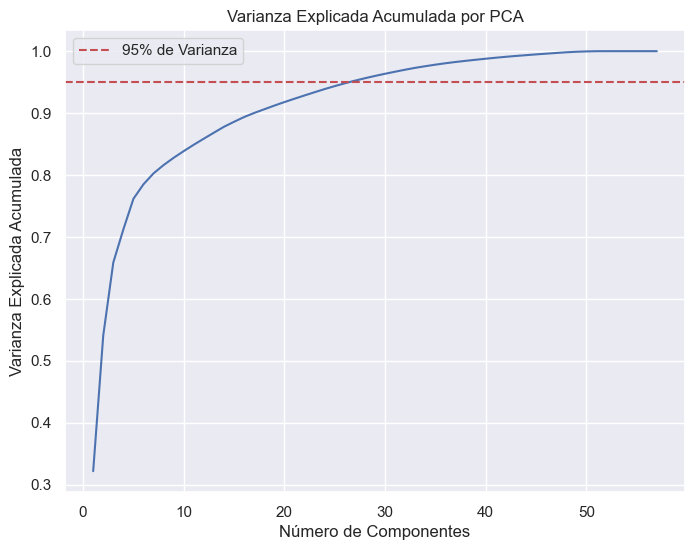

In [63]:
# 2º. Graficamos la varianza explicada acumulada
varianza_explicada = np.cumsum(pca.explained_variance_ratio_)  # Sumamos la varianza acumulada
# explained_variance_ratio_ representa la proporcion de varianza que cada componente principal explica
# con cumsum vamos haciendo la suma acumulada de las distintas proporciones de varianza de cada componente 

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(varianza_explicada) + 1), varianza_explicada)

# Configuramos grafico:
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Explicada Acumulada')
plt.title('Varianza Explicada Acumulada por PCA')
plt.grid(True)

# Creamos linea horizontal para ver donde queda el 95% de varianza
plt.axhline(y=0.95, color='r', linestyle='--', label='95% de Varianza')

plt.legend(loc='best')
plt.show()

In [64]:
# 3º. Ahora una vez hemos visto la grafica, y decididos a tener el 95 % de la varianza, aplicamos pca ya definitivo:
from sklearn.decomposition import PCA
pca_95 = PCA(n_components=0.95)  

# Aplicamos a los datos de entreno y de test. Ojo, recordad que fit solo es para entreno:
X_train_pca = pca_95.fit_transform(X_train[columnas_ohe])  
X_test_pca = pca_95.transform(X_test[columnas_ohe])  

# Número de componentes seleccionados
n_components = X_train_pca.shape[1] 

In [65]:
# Convertimos en DataFrame
# Debo darle nombre a las nueva columnas que se obtienen:
X_train_pca_df = pd.DataFrame(X_train_pca, columns=[f'PCA_{i+1}' for i in range(n_components)])
X_test_pca_df = pd.DataFrame(X_test_pca, columns=[f'PCA_{i+1}' for i in range(n_components)])

In [66]:
X_train = pd.concat([X_train[columnas_mantener], X_train_pca_df], axis=1)
X_test = pd.concat([X_test[columnas_mantener], X_test_pca_df], axis=1)

In [67]:
X_train

,accommodates,bathrooms,bedrooms,beds,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,...,PCA_18,PCA_19,PCA_20,PCA_21,PCA_22,PCA_23,PCA_24,PCA_25,PCA_26,PCA_27
0,0.5,0.0,0.0,0.0,-0.898560,-0.146828,-0.174903,-0.168126,0.032426,0.001843,...,0.000918,-0.000587,0.000360,0.000161,0.001102,-0.000185,0.002577,0.001366,0.000231,0.001736
1,0.5,1.0,1.0,0.5,-0.898560,-0.146828,-0.174903,-0.168126,0.032426,0.001843,...,0.000918,-0.000587,0.000360,0.000161,0.001102,-0.000185,0.002577,0.001366,0.000231,0.001736
2,-0.5,0.0,0.0,-0.5,-0.387768,-0.286606,0.092087,0.627440,-0.153424,-0.027257,...,-0.011445,0.001432,0.236850,-0.000797,-0.475992,0.007195,0.743633,0.003864,-0.255825,-0.056237
3,-1.0,1.0,0.0,-0.5,0.774455,0.652323,1.051776,-0.239926,0.032760,0.000724,...,-0.003680,-0.060241,-0.003001,-0.006392,-0.002707,0.041004,-0.011238,-0.003571,-0.000582,-0.004017
4,0.5,0.0,0.0,0.0,0.321884,-0.721482,1.124094,-0.250827,0.000583,-0.082050,...,0.000581,0.010507,0.000703,0.001046,0.000284,-0.004821,0.001541,0.000831,0.000666,0.001681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45638,-0.5,0.0,0.0,-0.5,0.081839,1.029642,0.220192,0.614321,-0.140310,-0.034858,...,-0.000628,0.001635,-0.030261,-0.001262,0.015982,0.000242,-0.011073,-0.005855,-0.026908,-0.010096
45639,0.5,0.0,1.0,0.0,0.300596,-0.675451,0.945515,-0.154920,-0.001417,-0.003344,...,-0.001986,-0.211057,0.002259,-0.035437,0.000570,0.839308,-0.006378,-0.015111,-0.004667,-0.000043
45640,2.0,0.0,2.0,0.5,-0.898560,-0.146828,-0.174903,-0.168126,0.032426,0.001843,...,0.000918,-0.000587,0.000360,0.000161,0.001102,-0.000185,0.002577,0.001366,0.000231,0.001736
45641,1.5,0.0,1.0,0.5,-0.898560,-0.146828,-0.174903,-0.168126,0.032426,0.001843,...,0.000918,-0.000587,0.000360,0.000161,0.001102,-0.000185,0.002577,0.001366,0.000231,0.001736


##### Todas columnas

En los tanteos realizados se ha procedido a probar qué sucedía aplicando PCA a todas las columnas, sin embargo, los resultados en la mayoría de los modelos muestran que es mejor aplicarlo solo a las columnas procedentes del OHE. Así, preservamos al 100% la información procedente de huéspedes, habitaciones, camas y baños.

In [55]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 1º Ajustamos PCA al subconjunto de entreno.
# No definimos el nº de componentes para así ver la varianza
pca = PCA()
pca = pca.fit(X_train)
pca

PCA()

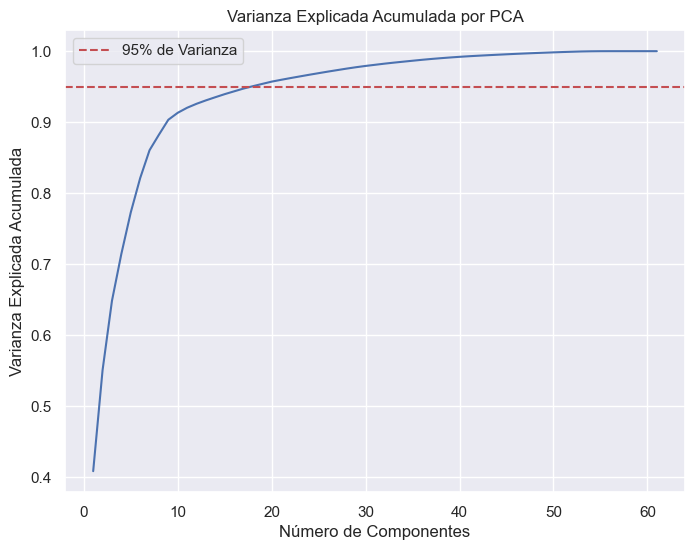

In [56]:
# 2º. Graficamos la varianza explicada acumulada
varianza_explicada = np.cumsum(pca.explained_variance_ratio_)  # Sumamos la varianza acumulada
# explained_variance_ratio_ representa la proporcion de varianza que cada componente principal explica
# con cumsum vamos haciendo la suma acumulada de las distintas proporciones de varianza de cada componente 

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(varianza_explicada) + 1), varianza_explicada)

# Configuramos grafico:
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Explicada Acumulada')
plt.title('Varianza Explicada Acumulada por PCA')
plt.grid(True)

# Creamos linea horizontal para ver donde queda el 95% de varianza
plt.axhline(y=0.95, color='r', linestyle='--', label='95% de Varianza')

plt.legend(loc='best')
plt.show()

In [57]:
# 3º. Ahora una vez hemos visto la grafica, y decididos a tener el 95 % de la varianza, aplicamos pca ya definitivo:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95)  

# Aplicamos a los datos de entreno y de test. Ojo, recordad que fit solo es para entreno:
X_train_pca = pca.fit_transform(X_train)  
X_test_pca = pca.transform(X_test)  

# Número de componentes seleccionados
n_components = X_train_pca.shape[1] 

In [58]:
# Convertimos en DataFrame
# Debo darle nombre a las nueva columnas que se obtienen:
X_train = pd.DataFrame(X_train_pca, columns=[f'PCA_{i+1}' for i in range(n_components)])
X_test = pd.DataFrame(X_test_pca, columns=[f'PCA_{i+1}' for i in range(n_components)])

In [61]:
X_train

,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,PCA_11,PCA_12,PCA_13,PCA_14,PCA_15,PCA_16,PCA_17,PCA_18
0,-0.374163,-0.997901,-0.154927,0.067983,0.118550,0.186261,0.228188,0.139322,-0.086044,0.003564,-0.011488,0.000418,-0.001154,-0.004299,0.000947,-0.000936,-0.003125,0.032790
1,-0.858755,0.173078,-0.712925,-0.302962,-0.087581,-0.921609,0.500897,0.120217,-0.078413,0.001595,-0.239848,0.002387,-0.002851,-0.001599,0.004474,-0.000273,-0.196599,0.007235
2,-1.338662,1.398904,0.509631,0.350982,-0.469700,0.293676,0.059226,-0.241386,-0.746407,-0.286568,-0.004759,0.018094,-0.015978,0.003713,0.006934,-0.000563,0.009524,0.041383
3,-1.216441,0.659418,0.025516,0.036075,0.278798,-1.037421,-0.398842,0.224863,-0.100344,-0.011336,-0.203546,0.001493,0.005170,-0.000697,0.005401,-0.016697,-0.172077,-0.003657
4,3.871666,-0.377740,1.327448,-0.111070,-0.646429,0.113930,-0.268990,0.202001,0.033430,0.001657,0.024512,0.002391,-0.003531,0.012285,-0.007447,0.011457,-0.000695,0.007426
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47362,-0.854322,0.190555,-0.756294,-0.308342,-0.094900,-1.126219,0.549567,0.216329,-0.112739,-0.066227,0.663862,-0.003321,-0.000256,-0.000820,0.001453,0.004525,0.109533,0.003691
47363,1.323366,-1.043959,-0.201125,-0.070755,0.153478,0.167663,-0.537668,0.175330,-0.043054,-0.008546,0.010267,-0.000763,0.002708,-0.003677,-0.006083,-0.006382,-0.002163,-0.017657
47364,0.658754,-0.683590,0.582492,-0.274134,-0.528954,0.148811,0.206642,0.158246,-0.054291,0.012495,-0.002768,0.001688,-0.004523,0.005436,-0.000910,0.009012,-0.003293,0.012378
47365,0.770211,0.605233,-0.724887,-0.081429,0.219292,0.315319,0.111800,-0.062216,-0.060402,0.303776,0.004659,-0.046746,0.053020,-0.002465,-0.001032,0.001516,-0.009136,0.017086


### Modelos de Machine Learning


#### Definición de métricas de evaluación de modelos

Antes de proceder a desarrollar los modelos, es fundamental definir las métricas con las que los evaluaremos.

¿Qué métricas usaremos?
Estamos ante un problema de regresión lineal. 
Por un lado, consideramos el coeficiente de determinación o R2. El cual nos será un indicativo de la variabilidad en los precios que mi modelo es capaz de explicar. Es decir, lo bien que generaliza el mismo.

Por otra parte, hemos descartado el uso del error cuadrático medio (MSE). El primer motivo es porque no queremos amplificar los errores, en especial ante los outliers en el precio que puedan encontrarse y que en caso de no ser capaz de poder predecirse correctamente darían lugar a errores aún más considerables. Por otro lado, no se encuentra en la magnitud del precio, lo cual hace menos intuitivo de analizar.

Optamos por lo tanto por usar el error absoluto medio MAE: ya que me permite interpretar los errores en la misma escala que en el precio, y no me penaliza tanto los errores, en especial los más grandes (ya que evitamos el cuadrado), haciendolo más robusto ante los posibles outliers que encontraramos en el precio en caso de que el modelo fuera incapaz de predecirlos bien.

In [104]:
print("Media total:", y.mean().round(2))
print("Mediana total:", y.median())

print("\nMedia entreno:", y_train.mean().round(2))
print("Mediana entreno:", y_train.median())

print("\nMedia test:", y_test.mean().round(2))
print("Mediana test:", y_test.median())

Media total: 107.88
Mediana total: 99.0

Media entreno: 107.82
Mediana entreno: 99.0

Media test: 108.06
Mediana test: 99.0


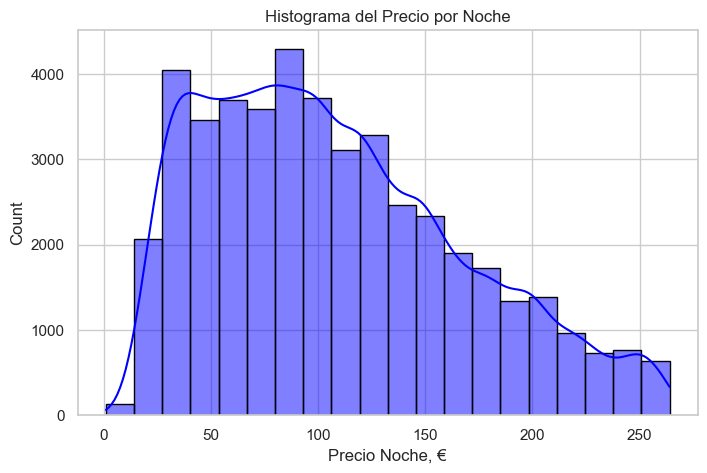

In [106]:
# Creamos un histograma del precio por noche:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))

sns.histplot(y_train, kde=True, bins=20, color='blue', edgecolor='black')
#sns.histplot(y_test, kde=True, bins=20, color='red', edgecolor='black')


# Defino etiquetas:
plt.xlabel("Precio Noche, €")
plt.title("Histograma del Precio por Noche")

# Mostramos el gráfico
plt.show()

El histograma muestra una distribucion sesgada a la derecha o con asimetría positiva. Los rangos de precios en los que oscilan la mayor parte se concentran entre 0 y 150 euros la noche. Esto no quita que haya otros precios mayores, cuya cantidad disminuye a medida que incrementa el precio noche. Por ello, con el MAE, evitamos que una hipotétitca mala predicción de lugar un error excesivo y con un peso mayor que el que realmente tiene en cómputos generales.

#### Algoritmos tipo K-Vecinos y Regresiones lineales

##### KNN


KNN es un algoritmo sensible a los datos no escalados, razón de más de haber escalado los valores previamente

In [116]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error

# Definimos el modelo de regresion KNN y lo entrenamos. En un primer momento, tanteo con 10 vecinos 
KNN_reg = KNeighborsRegressor(10).fit(X_train, y_train)

# Obtengo las predicciones para el conjunto de datos de testeo:
y_est = KNN_reg.predict(X_test)

In [117]:
# Obtener el MAE y el coeficiente R2
MAE_tst = mean_absolute_error(y_test, y_est)
R2_coeff = KNN_reg.score(X_test, y_test) # La misma función me da ya la predicción. R2 uno sería lo mejor

print("MAE:", MAE_tst)
print('R2 score: ' + str(R2_coeff))


MAE: 33.96453434111074
R2 score: 0.447877169628187


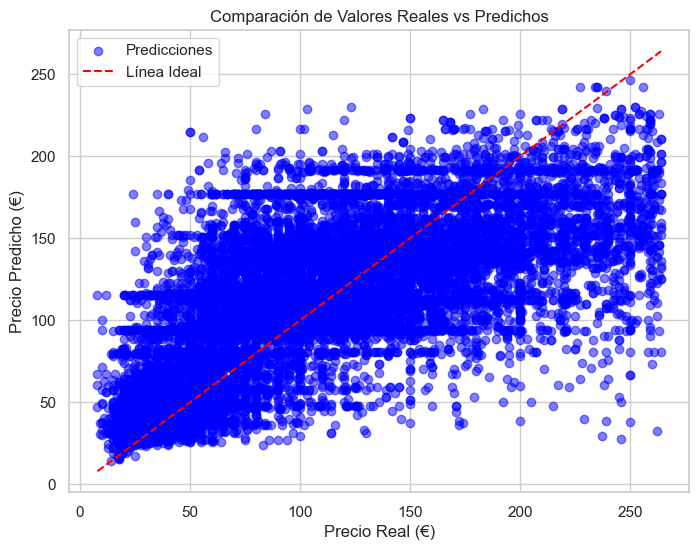

In [120]:
# Scatter plot de valores reales vs predicciones
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_est, alpha=0.5, color="blue", label="Predicciones")

# Añado linea ideal, donde precio predicho es igual al real:
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red", linestyle="dashed", label="Línea Ideal")

# Etiquetas y titulos
plt.xlabel("Precio Real (€)")
plt.ylabel("Precio Predicho (€)")
plt.title("Comparación de Valores Reales vs Predichos")
plt.legend()
plt.show()

Si todas las predicciones fueran perfectas, todos los puntos caerían sobre la línea. Valores por debajo de la linea, son predicciones subestimadas (precio real mayor del que predice) y por encima, sobreestimadas (precio predicho mayor que el real)

##### KNN optimizando vecinos


Vamos a intentar opitmizar distintos hiperparámetros:
- Probar con K optimo de vecinos
- Probar distintas métricas de distancia
- Usar pesos en los vecinos

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
# Vamos a intentar optimizar 3 hiperparámetros del algoritmo KNN:
# El nº de vecinos más cercanos, probaremos hasta un valor de 30
# La distancia utilizada para calcular esos k vecinos. Probamos Euclidea y Manhattan 
# La posibilidad de darle pesos a las distancias en funcion de las que estén mas cerca (distance, con respecto a uniforme)

k_max =30 
rang_K = np.arange(1, k_max+1)

tuned_parameters = [{
    'n_neighbors': rang_K,
    'metric': ['euclidean', 'manhattan'],
    'weights': ['uniform', 'distance']
}]

# Validacion cruzada con 5 folds:
nfold = 3 

# Definimos el modelo de regresion kNN con validación cruzada y entrenarlo
# Configurar CV para que devuelva las puntuaciones de entrenamiento
KNN_reg_CV = GridSearchCV(KNeighborsRegressor(), tuned_parameters, cv=nfold, return_train_score=True).fit(X_train, y_train)

# Obtener las predicciones para el conjunto de datos de testeo, con el mejor algoritmo de todos los que ha analizado
y_est = KNN_reg_CV.predict(X_test)

In [ ]:
# Se puede obtener los mejores parametros asi:
best_params = KNN_reg_CV.best_params_

# Imprimimos cada uno de ellos:
print("Mejores parámetros encontrados:")
print(f"n_neighbors: {best_params['n_neighbors']}")
print(f"metric: {best_params['metric']}")
print(f"weights: {best_params['weights']}")

In [ ]:
# Obtener el MAE y el coeficiente R2
MAE_tst = mean_absolute_error(y_test, y_est)
R2_coeff = KNN_reg_CV.score(X_test, y_test) # La misma función me da ya la predicción. R2 uno sería lo mejor

print("MAE:", MAE_tst)
print('R2 score: ' + str(R2_coeff))

##### Regresión lineal con mínimos cuadrados ordinarios

In [127]:
from sklearn import linear_model

# Definimos y entrenamos el modelo de regresion lineal
reg_lin = linear_model.LinearRegression().fit(X_train, y_train)

# Obtenemos las predicciones para el conjunto de datos de testeo
y_est = reg_lin.predict(X_test)


In [129]:
# Obtener el MAE y el coeficiente R2
MAE_tst = mean_absolute_error(y_test, y_est)
R2_coeff = reg_lin.score(X_test, y_test) # La misma función me da ya la predicción. R2 uno sería lo mejor

print("MAE:", MAE_tst)
print('R2 score: ' + str(R2_coeff))

MAE: 34.1881763584665
R2 score: 0.45170352991740326


##### Regresión lineal con mínimos cuadrados ordinarios y Regularización RIDGE

RIDGE es un alogoritmo de regresión lineal con regularización, la cual utilizamos para evitar el sobreaprendizaje del modelo. Utiliza para ello la regularización RIDGE o L2, la cual trabaja bien ante problemas complejos y un número elevado de entradas 

La alternativa podría ser sinos Lasso (o función de penalización L1), la cual puede anular coeficientes y es robusta ante ruido

Al usar Ridge, como sucede en el caso anterior de minimos cuadrados ordinarios, se utiliza un enfoque de optimización directa para resolver la regresión lineal. Este modelo encuentra los coeficientes que minimizan la función de pérdida, pero no se realiza una optimización iterativa como en el caso de los algoritmos basados en gradiente descendente. En su lugar, se resuelve mediante una solución cerrada (en la que se calcula directamente la solución analítica usando álgebra lineal).

In [135]:
from sklearn.linear_model import Ridge

# Definimos y entrenamos el modelo de regresion lineal. Usamos parametro de regularizacion por defecto, alpha = 1
reg_lin_ridge = Ridge().fit(X_train, y_train)

# Obtenemos predicciones:
y_est = reg_lin_ridge.predict(X_test)

In [137]:
# Obtener el MAE y el coeficiente R2
MAE_tst = mean_absolute_error(y_test, y_est)
R2_coeff = reg_lin_ridge.score(X_test, y_test) # La misma función me da ya la predicción. R2 uno sería lo mejor

print("MAE:", MAE_tst)
print('R2 score: ' + str(R2_coeff))

MAE: 34.18794386675136
R2 score: 0.45170355007284


##### Regresión lineal con mínimos cuadrados ordinarios y Regularización RIDGE optimizada

Vamos a aplicar GridSearchCV para establecer cual es el hiperparámetro alpha que optimice el modelo y nos de el menor error

In [141]:
from sklearn.model_selection import GridSearchCV

# Usamos escala logaritmica para ver cómo afecta el parametro alpha al modelo a través de distintos ordenes de magnitud
# Consideraremos el siguiente rango, de 10 valores entre 0.001 y 10:
rang_alpha = np.logspace(-3, 1, 10)
tuned_parameters = [{'alpha': rang_alpha}] 
nfold = 5 #Particiones validacion cruzada. 

# Definimos el modelo de regresion lineal RIDGE con validación cruzada y lo entrenamos.
# Configuramos CV para que devuelva las puntuaciones de entrenamiento (return_train score true)
ridge_CV = GridSearchCV(Ridge(), tuned_parameters, cv = nfold, return_train_score = True).fit(X_train, y_train)

# Obtenemos las predicciones para el conjunto de datos de testeo
y_est = ridge_CV.predict(X_test)

In [142]:
# Se puede obtener los mejores parametros asi:
best_params = ridge_CV.best_params_

# Imprimimos cada uno de ellos:
print("Mejores parámetros encontrados:")
print(f"Parámetro de regularización: {best_params['alpha']}")

Mejores parámetros encontrados:
Parámetro de regularización: 3.593813663804626


In [143]:
# Obtener el MAE y el coeficiente R2
MAE_tst = mean_absolute_error(y_test, y_est)
R2_coeff = ridge_CV.score(X_test, y_test) # La misma función me da ya la predicción. R2 uno sería lo mejor

print("MAE:", MAE_tst)
print('R2 score: ' + str(R2_coeff))

MAE: 34.1873579240421
R2 score: 0.4517032171284189


##### Regresión lineal mediante descenso de gradiente

Recordar del punto anterior, cuando usas LinearRegression, el algoritmo no hace optimización iterativa como el descenso de gradiente. 
En lugar de eso, resuelve directamente la ecuación de la regresión usando álgebra lineal, específicamente la fórmula de los mínimos cuadrados ordinarios (OLS, por sus siglas en inglés). 

Esta es una solución cerrada, no un proceso iterativo. Es como si, en vez de probar diferentes combinaciones de parámetros y mejorar poco a poco, 
el algoritmo calcula directamente el valor óptimo de β usando las características de todos los datos a la vez, sin pasar por múltiples iteraciones.

Por otro lado, el SGDRegressor sí optimiza los parámetros de forma iterativa mediante descenso de gradiente estocástico. 
En este caso, los parámetros β se ajustan poco a poco en función de los gradientes de la función de error con respecto a cada parámetro. 

Este proceso se repite en varias iteraciones hasta que los parámetros convergen a un valor óptimo (o lo suficientemente cercano al óptimo).

In [148]:
from sklearn.linear_model import SGDRegressor

# Definimos y entrenamos el modelo 
reg_lin_SGD = SGDRegressor().fit(X_train, y_train)

# Obtenemos predicciones:
y_est = reg_lin_SGD.predict(X_test)

In [150]:
# Obtener el MAE y el coeficiente R2
MAE_tst = mean_absolute_error(y_test, y_est)
R2_coeff = reg_lin_SGD.score(X_test, y_test) 

print("MAE:", MAE_tst)
print('R2 score: ' + str(R2_coeff))

MAE: 34.22996686936843
R2 score: 0.4515708029723722


##### Regresión lineal mediante descenso de gradiente optimizado

Vamos a intentar optimizar hiperparámetros mediante GridSearchCV

- Funcion de penalizacion: para evitar el sobreaprendizaje del modelo SGDRegressor usa por defecto RIDGE o L2, pero
  puedo probar con Lasso (L1) o ElasticNet, combinación de ambos.

- Parámetro de regularización (alpha): para regular la intensidad de la regularización, como en casos anteriores, probamos usando una escala logarítmica
  para así ver como cambia el modelo ante distintas magnitudes en los valores (proporcionado por esa escala logarítimica). Por defecto, se usa 0.0001

- Máximo numero de iteraciones: si me quedo corto, el modelo no converge adecuadamente, no dandole suficiente tiempo para encontrar la solución óptima,
  si me paso, puedo estar ajustando innecesariamente (ya ha convergido a la solución) y/o puede haber sobreajuste. 

- Learning rate: establece cuanto se ajustan los parametros en cada iteracion del proceso de optimizacion (en este caso, mediante descenso gradiente).
  El valor inicial o también llamado tasa de aprendizaje, se puede ajustar en el hiperparámetro eta0. Cuyo valor por defecto es 0.01.

  Mientras, en el hiperparámetro learning rate tengo la opción de definir como cambia la tasa de aprendizaje en cada iteración. Tengo 4 opciones:

    - constante: eta0 será siempre el mismo. Es la opción de learning rate por defecto. Si además no cambio eta0, será 0.01.

    - óptimo: calcula autoamticamente eta0 según la regularización alpha. Aqúi no defino yo el valor de eta0, se calcula automáticamente en
        función de el parametro de regularización alpha y el nº de iteraciones. 

    - invscaling: disminuye el valor eta0 a medida que aumentan las iteraciones. Util si quiero que se ajuste el modelo 1º rapido y luego + lento

    - adaptativo: reduce eta0 si la perdida no mejora durante varias iteraciones. Util si con constante no converge bien.

- Loss: funcion de predida que el modelo minimiza durante el entreno. Puede tener gran impacto. Existen distintas opciones

    - squared_error: es el error cuadratico medio. la más común, me penalizará fuertemente los errores grandes. Sensible a outliers grandes

    - huber: combi de MSE y error absoluto. Penaliza de forma cuadratica errores pequeños y los grandes linea. Menos sensible a outliers

    - epsilon_INSENSITIVE: se define margen de inensibildiad. de forma que errores pqeuños a un epsilon no afectan a la fucion de perdia.
        es decir el modelo no penaliza los errores pqueños, y los mayors a epsilon se penalizan linealemnte.
 
    - squared epsilon insensitive: igual que la anterior pero erorres mayoresa epsilon se penalizan cuadraticamente. 
  

In [ ]:
from sklearn.model_selection import GridSearchCV

# Consideraremos las siguientes opciones de regularizacion:
rang_alpha = np.logspace(-3, 1, 10) #  De 0.001 a 10

# Como probando de 0.001 a 10, me sale 0.001, probare con alphas más debiles. Es decir, una regularización más debil.
nfold = 5 #Particiones validacion cruzada. 


param_grid = {
   'alpha': rang_alpha,
   'penalty': ['l1', 'l2', 'elasticnet'],
    # 'max_iter': [1000, 5000, 100000],
    'loss' : ['squared_error','huber','epsilon_insensitive','squared_epsilon_insensitive'],
    # 'loss' : ['squared_error','huber']
     'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
     'eta0': [0.0001, 0.001, 0.01, 0.1]
}


# Definimos el modelo de regresion lineal con validación cruzada y lo entrenamos
SGD_CV = GridSearchCV(SGDRegressor(max_iter=1000000), param_grid, cv = nfold, return_train_score = True).fit(X_train, y_train)

# Obtenemos las predicciones para el conjunto de datos de testeo
y_est = SGD_CV.predict(X_test)

In [ ]:
# Se puede obtener los mejores parametros asi:
best_params = SGD_CV.best_params_

# Imprimimos cada uno de ellos:
print("Mejores parámetros encontrados:")

print(f"Parámetro de regularización: {best_params['penalty']}")
print(f"Parámetro de regularización: {best_params['alpha']}")

print(f"Parámetro de regularización: {best_params['loss']}")
# print(f"Parámetro de regularización: {best_params['max_iter']}")
print(f"Parámetro de regularización: {best_params['learning_rate']}")
print(f"Parámetro de regularización: {best_params['eta0']}")

In [ ]:
# Obtener el MAE y el coeficiente R2
MAE_tst = mean_absolute_error(y_test, y_est)
R2_coeff = SGD_CV.score(X_test, y_test) 

print("MAE:", MAE_tst)
print('R2 score: ' + str(R2_coeff))

#### Algoritmos de Árboles de Decisión

Dado que individualmente los modelos predictivos no nos han proporcionado unos resultados excelentes, vamos a usar los métodos de ensamblaje, que consisten en utilizar múltiples algoritmos.
Recordar que para construir estos ensembles o ensamblajes, nos interesará utilizar modelos base tipo débiles, puesto que pese a que son por sí mismos poco precisos, son rápidos de entrenar. Por ejemplo, son tipo débil los arboles de decisión y la regresión lineal. 

En este proyecto vamos a analizar los resultados que nos proporcionan las dos tipologías de ensembles: 

- Paralelos, en los que cada modelo base trabaja en paralelo sobre los datos, de forma que la predicción de todos ellos se combina. La estrategia principal utilizada es el Bagging

- Secuenciales, basados en que cada modelo busca corregir los errores del modelo anterior. La estrategia principal de estos es el boosting

**Bagging**

En una situación ideal donde tuvieramos una gran cantidad de datos, los modelos base que constituyen los ensembles paralelos trabajarían con una muestra aleatoria de datos, siendo totalmente independientes entre ellos. Sin embargo, esto no es lo que suele ocurrir, de ahí que se precisa hacer uso de la técnica bagging. 

En ella, cada modelo toma una muestra aleatoria de datos con reemplazo, del mismo tamaño que los datos originales (muestra boostrap). Por lo general, en bagging los modelos base son del mismo tipo y tienen el mismo peso en la predicción final. En nuestro caso, la media aritmética.

Dada la no situacion ideal de datos y por lo tanto, el hecho de compartir patrones entre todos los modelos, hará que nos interesen que los modelos base sean modelos insetables, es decir, que sean sensibles a perturbaciones en los datos -> pequeños cambios provoquen grandes cambios en el resultado. Inestables son por ejemplo los arboles de decision. 

**Boosting**

Los modelos secuenciales se basan en la técnica Boosting, donde el modelo base debe centrarse en los errores cometidos por el modelo base anterior. No es tan crítico que los modelos base sean inestables pero sí deseable; también que sean débiles, ya que si de inicio predicen con pocos errores (propio de fuertes) poco habrá que corregir.

Por lo tanto, también nos interesará trabajar con árboles de decisión.

##### Random Forest

Algoritmo tipo bagging de árboles de decisión (árboles sobre muestras Boostrap). 

- La combinación de los árboles se realiza mediante media simple!
- Al usar árboles, es fácil controlar su debilidad/fortaleza mediante parametros: profunidad, patrones...
- Árboles son rápidos de entrenar (son débiles), paralelizables y facilmente interpretables.
- Para evitar que todos los árboles usen una misma variable que tenga mucho poder expliativo, y con ello, perjudicar la diversidad, la técnica RF hace un bagging con las variables: en cada corte en un nodo, en vez de evaluar todas las variables se hace sobre un subconjunto aleatorio.



In [176]:
# Vamos a intentar averiguar cual es el nº de estimadores ideal, pues no me quiero quedar corto (no alcanzo mejor resultado)
# ni tampoco pasarme (no mejorará por much que ponga de mas). Uso para ello también como antes GridSearchCV
from sklearn.model_selection import GridSearchCV

#Random Forest no elige un algoritmo pues está definido para utilizar arboles de decision (decision trees) 
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Rango de estimadores o modelos base que probaremos
rango_arboles = np.arange(1,30)
tuned_parameters = [{'n_estimators': rango_arboles}]
nfold=3

# Entreno en el modelo buscando el nº optimo de arboles
RF_opt = GridSearchCV(RandomForestRegressor(), tuned_parameters, cv=nfold).fit(X_train, y_train)

# El nº optimo es:
n_trees_opt =RF_opt.best_estimator_.n_estimators
print("The number of selected trees is " + str(n_trees_opt))

# Hago predicciones:
y_predict = RF_opt.best_estimator_.predict(X_test)

# Evaluo mediante MAE y R2:
MAE_RF_opt = mean_absolute_error(y_test, y_predict)
R2_RF_opt =RF_opt.score(X_test, y_test) 

print("MAE is ", MAE_RF_opt.round(2))
print("The test R2 of the RF is ", R2_RF_opt)

The number of selected trees is 28
MAE is  31.62
The test R2 of the RF is  0.5


Puedo intentar optimizar más hiperparámetros:

In [ ]:
from sklearn.model_selection import GridSearchCV

#Random Forest no elige un algoritmo pues está definido para utilizar arboles de decision (decision trees) 
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Parrilla de parámetros que buscamos optimizar: 
rango_arboles = np.arange(1,5)
tuned_parameters = [{
    'n_estimators': rango_arboles, # nº de arboles o modelos base 

    'max_samples': [0.5, 0.75, None], # % muestra de datos utilizado para el bootstrap. Por defecto (None) todas
    'max_features': [0.5, 0.75, None], # % de variables aleatorias considerardas en cada division. Por defecto (None) todas
    
    'max_depth': [10, 20, None] # profundidad maxima del arbol. Por defecto (None) hasta final o se cumple minimo splits
                                  # (controla sobreajuste -> más probable a mayores profundidades, ya que habrá pocos datos)
    
    #'min_samples_split': [2, 5, 10], # nº minimo de muestras para dividir nodo. Por defecto, 2
                                     #valores más altos ayudan a evitar sobreaprendizaje
    #'min_samples_leaf': [1, 2, 4] # nº minimo muestras en hoja. Por defecto, 1. Lo mismo que antes, para el sobreajuste


}]
nfold=3


# Entreno en el modelo buscando el nº optimo de arboles
RF_opt = GridSearchCV(RandomForestRegressor(criterion='absolute_error'), tuned_parameters, cv=nfold, scoring='neg_mean_absolute_error').fit(X_train, y_train)

# Criterion es el critero utilizado para medir el error a la hora de hacer el mejor corte de un nodo
# como evaluo a posteriori con MAE uso?? también este criterio para el corte. 
# criterion='absolute_error'

# En gridsearchcv, el scoring define la métrica que se usará para evaluar cada combinación de hiperparámetros y así seleccionar la mejor (mejor modelo)
# manteniendo coherencia utilizada en el criteiro de corte, y en la metrica posteriori de evaluar modelo optimo, uso error absoluto medio????
# scoring='r2'
# scoring='neg_mean_absolute_error'
### Valores optimos de hiperparametros: El nº optimo es:
best_params = RF_opt.best_params_
print("Best parameters found: ", best_params)

# Nº estimadores o modelos base:
n_trees_opt = RF_opt.best_estimator_.n_estimators
print("The number of selected trees is " + str(n_trees_opt))
# % variables:
max_features_opt = RF_opt.best_estimator_.max_features
print("The selected max features is " + str(max_features_opt))
# % muestra:
max_samples_opt = RF_opt.best_estimator_.max_samples
print("The selected max samples is " + str(max_samples_opt))
# maxima profundidad:
max_depth_opt = RF_opt.best_estimator_.max_depth
print("The selected max depth is " + str(max_depth_opt))
# minimo muestras para corte 
min_samples_split_opt = RF_opt.best_estimator_.min_samples_split
print("The selected min samples split is " + str(min_samples_split_opt))
# minimo muestras para hoja
min_samples_leaf_opt = RF_opt.best_estimator_.min_samples_leaf
print("The selected min samples leaf is " + str(min_samples_leaf_opt))


# Hago predicciones con el modelo optimo:
y_predict = RF_opt.best_estimator_.predict(X_test)

# Evaluo mediante MAE y R2:
MAE_RF_opt = mean_absolute_error(y_test, y_predict)
R2_RF_opt =RF_opt.score(X_test, y_test) 

print("MAE is ", MAE_RF_opt.round(2))
print("The test R2 of the RF is ", R2_RF_opt.round(2))

Vamos a probar a analizar el rendimiento del ensamblaje (mediante r2) según varía el nº de estimadores. Para obtener resultados estadísticamente significativos (pues hay que tener en cuenta la aleatoriedad sobre el subconjunto de entreno, subconjunto de variables, del modelo en si...) promediamos sobre 20 ejecuciones diferentes para cada cantidad específica de estimadores.

In [178]:
# Semilla de aleatoriedad
np.random.seed(0)

r2_test_evol = [] 
rango_estimadores = range(1,50,2) #nº de arboles de 1 a 50, pero de 2 en 2

for n_learners in rango_estimadores:
    r2_test_run=[]
    for run in range(10):
        RF_opt = RandomForestRegressor(n_learners, max_samples=0.5, max_features=0.5).fit(X_train, y_train)
        r2 = RF_opt.score(X_test, y_test)
        r2_test_run.append(r2)
    r2_test_evol.append(np.mean(r2_test_run))

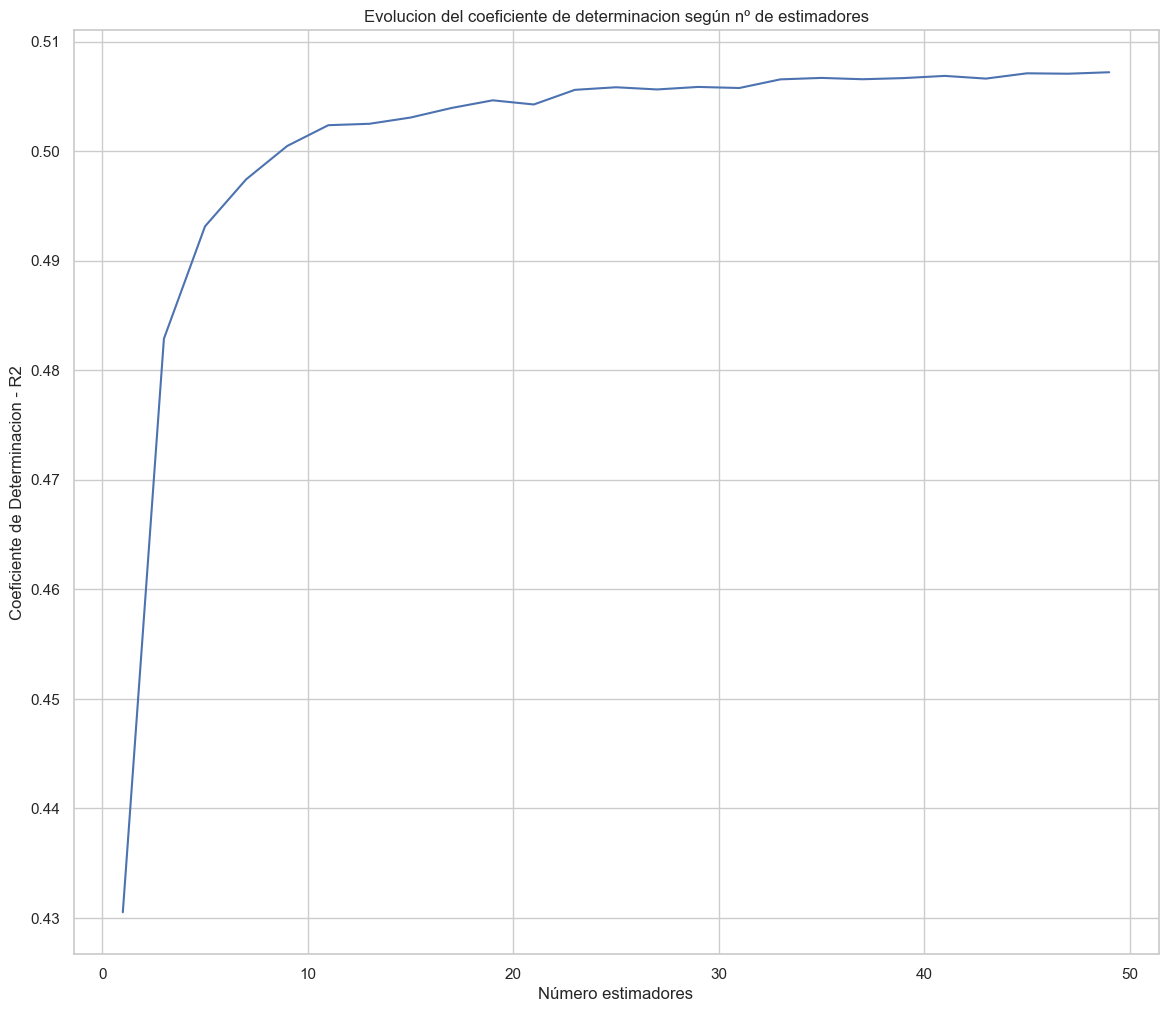

In [179]:
# Graficamos resultados
plt.figure()
plt.plot(rango_estimadores, r2_test_evol)
plt.xlabel('Número estimadores')
plt.ylabel('Coeficiente de Determinacion - R2')
plt.title('Evolucion del coeficiente de determinacion según nº de estimadores')
plt.show()

##### Extremely Randomized Trees

Este se caracteriza por:
- También escoge subconjunto de variables al hacer un corte
- El punto de corte en cada nodo no se hace buscando minimizar el error al dividir variable en dos, sino que se escoge aleatoriamente
- Se construyen sobre todos los datos, sin sacar muestras Bootstrap (lo compensa con la aleatoriedad de los cortes)

In [181]:
# Vamos a intentar averiguar cual es el nº de estimadores ideal, pues no me quiero quedar corto (no alcanzo mejor resultado)
# ni tampoco pasarme (no mejorará por much que ponga de mas). Uso para ello también como antes GridSearchCV
from sklearn.model_selection import GridSearchCV

#ETR no elige un algoritmo pues está definido para utilizar arboles de decision (decision trees) 
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_absolute_error

# Rango de estimadores o modelos base que probaremos
rango_arboles = np.arange(1,30)
tuned_parameters = [{'n_estimators': rango_arboles}]
nfold=3

# Entreno en el modelo buscando el nº optimo de arboles
ETR_opt = GridSearchCV(ExtraTreesRegressor(), tuned_parameters, cv=nfold).fit(X_train, y_train)

# El nº optimo es:
n_trees_opt =ETR_opt.best_estimator_.n_estimators
print("The number of selected trees is " + str(n_trees_opt))

# Hago predicciones con el modelo optimo:
y_predict = ETR_opt.best_estimator_.predict(X_test)

# Evaluo mediante MAE y R2:
MAE_ETR_opt = mean_absolute_error(y_test, y_predict)
R2_ETR_opt =ETR_opt.score(X_test, y_test) 

print("MAE is ", MAE_ETR_opt.round(2))
print("The test R2 of the RF is ", R2_ETR_opt)

The number of selected trees is 21
MAE is  31.63
The test R2 of the RF is  0.49


Puedo intentar optimizar más hiperparámetros:

In [224]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_absolute_error

# Parrilla de parámetros que buscamos optimizar: 
rango_arboles = np.arange(1,5)
tuned_parameters = [{
    'n_estimators': rango_arboles, # nº de arboles o modelos base 

    'max_features': [0.5, 0.75, None], # % de variables aleatorias considerardas en cada division. Por defecto (None) todas
    
    'max_depth': [10, 20, None], # profundidad maxima del arbol. Por defecto (None) hasta final o se cumple minimo splits
                                  # (controla sobreajuste -> más probable a mayores profundidades, ya que habrá pocos datos)
    
    'min_samples_split': [2, 5, 10], # nº minimo de muestras para dividir nodo. Por defecto, 2
                                     #valores más altos ayudan a evitar sobreaprendizaje
    'min_samples_leaf': [1, 2, 4] # nº minimo muestras en hoja. Por defecto, 1. Lo mismo que antes, para el sobreajuste


}]
nfold=5


# Entreno el modelo buscando el nº óptimo de árboles
ETR_opt = GridSearchCV(ExtraTreesRegressor(), tuned_parameters, cv=nfold).fit(X_train, y_train)

# Criterion es el critero utilizado para medir el error a la hora de hacer el mejor corte de un nodo
# como evaluo a posteriori con MAE uso?? también este criterio para el corte. 
# criterion='absolute_error'
# Aunque las características y los umbrales son seleccionados aleatoriamente,
# el criterion determina cuál de esos cortes aleatorios es el "mejor" según la métrica que elijas.

# En gridsearchcv, el scoring define la métrica que se usará para evaluar cada combinación de hiperparámetros y así seleccionar la mejor (mejor modelo)
# manteniendo coherencia utilizada en el criteiro de corte, y en la metrica posteriori de evaluar modelo optimo, uso error absoluto medio????
# scoring='r2'

### Valores optimos de hiperparametros: El nº optimo es:
best_params = ETR_opt.best_params_
print("Best parameters found: ", best_params)

# Nº estimadores o modelos base:
n_trees_opt = ETR_opt.best_estimator_.n_estimators
print("The number of selected trees is " + str(n_trees_opt))
# % variables:
max_features_opt = ETR_opt.best_estimator_.max_features
print("The selected max features is " + str(max_features_opt))
# maxima profundidad:
max_depth_opt = ETR_opt.best_estimator_.max_depth
print("The selected max depth is " + str(max_depth_opt))
# minimo muestras para corte 
min_samples_split_opt = ETR_opt.best_estimator_.min_samples_split
print("The selected min samples split is " + str(min_samples_split_opt))
# minimo muestras para hoja
min_samples_leaf_opt = ETR_opt.best_estimator_.min_samples_leaf
print("The selected min samples leaf is " + str(min_samples_leaf_opt))


# Hago predicciones con el modelo optimo:
y_predict = ETR_opt.best_estimator_.predict(X_test)

# Evaluo mediante MAE y R2:
MAE_ETR_opt = mean_absolute_error(y_test, y_predict)
R2_ETR_opt =ETR_opt.score(X_test, y_test) 

print("MAE is ", MAE_ETR_opt.round(2))
print("The test R2 of the RF is ", R2_ETR_opt.round(2))

The number of selected trees is 36
MAE is  16.69
The test R² of the ETR is  0.56


Analizamos el rendimiento del ensamblaje (mediante r2) según varía el nº de estimadores:

In [ ]:
# Semilla de aleatoriedad
np.random.seed(0)

r2_test_evol = [] 
rango_estimadores = range(1,50,2) #nº de arboles de 1 a 50, pero de 2 en 2

for n_learners in rango_estimadores:
    r2_test_run=[]
    for run in range(10):
        ETR_opt = ExtraTreesRegressor(n_learners, max_features=0.5).fit(X_train, y_train)
        r2 = ETR_opt.score(X_test, y_test)
        r2_test_run.append(r2)
    r2_test_evol.append(np.mean(r2_test_run))

In [ ]:
# Graficamos resultados
plt.figure()
plt.plot(rango_estimadores, r2_test_evol)
plt.xlabel('Número estimadores')
plt.ylabel('Coeficiente de Determinacion - R2')
plt.title('Evolucion del coeficiente de determinacion según nº de estimadores')
plt.show()

##### Adaboost

Es el algoritmo más popular de tipo Boosting. Los modelos base utilizados son normalmente árboles, aunque no necesariamente deben serlo. 

Bagging se utiliza frecuentemente cuando tengo pocos datos, ya que usa boostraping. Mientras que si tengo suficientes datos para entrenar un modelo, suele usarse boosting.
Los resultados entre una metodología u otra pueden ser similares, pero hay que tener en cuenta que cuando tengo muchos datos, boosting es ideal, los mejores modelos nos los va a dar boosting.

In [637]:
# Vamos a intentar averiguar cual es el nº de estimadores ideal, pues no me quiero quedar corto (no alcanzo mejor resultado)
# ni tampoco pasarme (no mejorará por much que ponga de mas). Uso para ello también como antes GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_absolute_error


# Rango de estimadores o modelos base que probaremos
rango_arboles = np.arange(1,30)
tuned_parameters = [{'n_estimators': rango_arboles}]
nfold=3

# Entreno en el modelo buscando el nº optimo de arboles
AB_opt = GridSearchCV(AdaBoostRegressor(), tuned_parameters, cv=nfold).fit(X_train, y_train)


# El nº optimo es:
n_trees_opt =AB_opt.best_estimator_.n_estimators
print("The number of selected trees is " + str(n_trees_opt))

# Hago predicciones con el modelo optimo:
y_predict = AB_opt.best_estimator_.predict(X_test)

# Evaluo mediante MAE y R2:
MAE_AB_opt = mean_absolute_error(y_test, y_predict)
R2_AB_opt =AB_opt.score(X_test, y_test) 

print("MAE is ", MAE_AB_opt.round(2))
print("The test R2 of the RF is ", R2_AB_opt)

The number of selected trees is 5
MAE is  30.25
The test R2 of the RF is  0.43


Se puede intentar optimizar más hiperparámetros:

In [170]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor

# Por defecto (aunque puede usar otros algortimos), Adaboost utiliza arboles de decision con max_depth = 3
# Como vamos a intentar optimizar alguno de sus parametros, entre ellos el max_depth comemntado, definiremos el modelo igualmente,
# como arboles de decision (Pero sin las hiperparametros a optimizar a posteriri definidos dentro, solo lo que mantendre fijo)
base_model = DecisionTreeRegressor(criterion='absolute_error')

# Parrilla de parámetros que buscamos optimizar: 
rango_arboles = np.arange(1,5)
tuned_parameters = [{
    
    # Hiperparámetros propios de Adaboost:
    'n_estimators': rango_arboles, # nº de arboles o modelos base a utilizar 
    # 'learning_rate': [0.01, 0.1, 0.5, 1.0],
    
                     #tasa de aprendizaje. Peso aplicado a cada regressor en cad aiteracion.
                     # controla cuanto contribuye cada modelo debil a la prediccion final. Valores bajos: aprendizaje lento, más iteraciones
                     # valores altos, aprendizaje rapido, pero puede sobreajustar
    
    # 'loss': ['linear', 'square', 'exponential']
                    # la funcion de perdida utilizada para actualizar pesos tras cada iteracion. 
                    # Square eleva errore sal cuadrado, y exp. aun penaliza mas

    # Hiperparámetros del modelo base (arboles de decision): El estimator delante indica que son del modelo base: 
    # NO USARLO!!
    # 'estimator__max_depth': [10, 20, None], # profundidad maxima del arbol. Por defecto (None) hasta final o se cumple minimo splits
    #                                        # (controla sobreajuste -> más probable a mayores profundidades, ya que habrá pocos datos)
    
    'estimator__min_samples_split': [2, 5, 10], # nº minimo de muestras para dividir nodo. Por defecto, 2
                                                #valores más altos ayudan a evitar sobreaprendizaje
    
    'estimator__min_samples_leaf': [1, 2, 4]   # nº minimo muestras en hoja. Por defecto, 1. Lo mismo que antes, para el sobreajuste

}]
nfold=3


# Entreno en el modelo buscando el nº optimo de arboles
AB_opt = GridSearchCV(AdaBoostRegressor(estimator=base_model), tuned_parameters, cv=nfold).fit(X_train, y_train)

# Criterion es el critero utilizado para medir el error a la hora de hacer el mejor corte de un nodo
# como evaluo a posteriori con MAE uso?? también este criterio para el corte. 
# criterion='absolute_error'

# En gridsearchcv, el scoring define la métrica que se usará para evaluar cada combinación de hiperparámetros y así seleccionar la mejor (mejor modelo)
# manteniendo coherencia utilizada en el criteiro de corte, y en la metrica posteriori de evaluar modelo optimo, uso error absoluto medio????
# scoring='r2'


# Obtener los mejores hiperparámetros encontrados por GridSearchCV
best_params = AB_opt.best_params_
print("Best parameters found:", best_params)

# nº modelos base:
n_trees_opt = AB_opt.best_estimator_.n_estimators
print("The number of selected trees is:", n_trees_opt)
# # learning rate:
# learning_rate_opt = AB_opt.best_estimator_.learning_rate
# print("The selected learning rate is:", learning_rate_opt)
# # funcion perdida:
# loss_opt = AB_opt.best_estimator_.loss
# print("The selected loss function is:", loss_opt)
# # maxima profundidad:
# max_depth_opt = AB_opt.best_estimator_.max_depth
# print("The selected max depth is " + str(max_depth_opt))
# minimo muestras para corte 
min_samples_split_opt = AB_opt.best_estimator_.estimator_.min_samples_split
print("The selected min samples split is " + str(min_samples_split_opt))
# minimo muestras para hoja
min_samples_leaf_opt = AB_opt.best_estimator_.estimator_.min_samples_leaf
print("The selected min samples leaf is " + str(min_samples_leaf_opt))


# Hacemos predicciones con el modelo óptimo
y_predict = AB_opt.best_estimator_.predict(X_test)

# Evaluar mediante MAE y R²
MAE_AB_opt = mean_absolute_error(y_test, y_predict)
R2_AB_opt = AB_opt.score(X_test, y_test)

print("MAE is:", round(MAE_AB_opt, 2))
print("The test R² of the AdaBoost model is:", round(R2_AB_opt, 2))

Best parameters found: {'estimator__min_samples_leaf': 4, 'estimator__min_samples_split': 5, 'n_estimators': 4}
The number of selected trees is: 4
The selected min samples split is 5
The selected min samples leaf is 4
MAE is: 17.17
The test R² of the AdaBoost model is: 0.52


No tiene sentido usar AdaBoost con árboles de decisión de gran profundidad, ya que el objetivo de AdaBoost es crear un modelo fuerte a partir de modelos base débiles. Los árboles muy profundos pueden llevar a sobreajuste, disminuyendo el beneficio de AdaBoost. Usa árboles pequeños, típicamente con max_depth entre 1 y 5.

AdaBoost se diseñó para trabajar con modelos base débiles (como árboles de decisión con profundidad pequeña, típicamente de 1 a 5). Un árbol de profundidad 3 (por defecto en DecisionTreeRegressor cuando se usa con AdaBoost) es considerado "débil", y esta debilidad es precisamente lo que permite a AdaBoost combinar muchos modelos y aprender patrones complejos.

Veo también como evoluciona según nº estimadores:

In [159]:
# Semilla de aleatoriedad
np.random.seed(0)

r2_test_evol = [] 
rango_estimadores = range(1,200,5) #nº de arboles de 1 a 50, pero de 2 en 2

for n_learners in rango_estimadores:
    r2_test_run=[]
    for run in range(1):
        AB_opt = AdaBoostRegressor(DecisionTreeRegressor(), n_estimators=n_learners).fit(X_train, y_train)
        r2 = AB_opt.score(X_test, y_test)
        r2_test_run.append(r2)
    r2_test_evol.append(np.mean(r2_test_run))

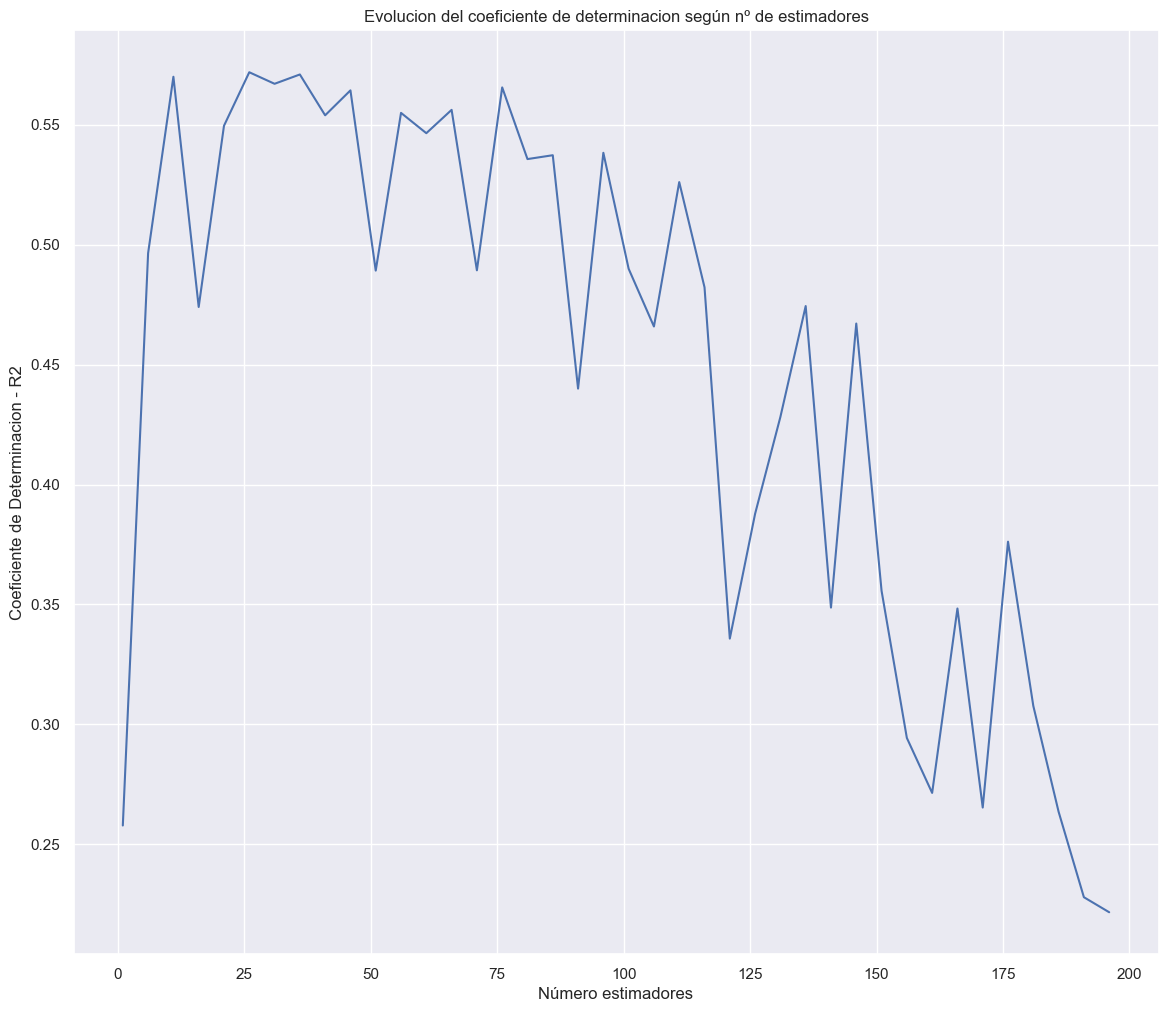

In [160]:
# Graficamos resultados
plt.figure()
plt.plot(rango_estimadores, r2_test_evol)
plt.xlabel('Número estimadores')
plt.ylabel('Coeficiente de Determinacion - R2')
plt.title('Evolucion del coeficiente de determinacion según nº de estimadores')
plt.show()

##### XGBOOST

Otro algoritm de Boosting, donde usamos la misma técnica pero procedente de otra librería distinta. Eso sí, utilizable dentro de los patrones de programación de la librería sklearn. 

Es una librería de Machine Learning optimizada para problemas de aprendizaje supervisado, especialmente en tareas de clasificación y regresión. Se basa en el algoritmo de Gradient Boosting, mejorándolo en términos de eficiencia, rendimiento y flexibilidad. Se caracteriza por:

- Alto rendimiento: Implementado en C++, lo que lo hace más rápido que otras implementaciones de Gradient Boosting.

- Optimización con paralelización: Aprovecha múltiples núcleos para entrenar más rápido.
Ojo es secuencial para construir los árboles, pues cad uno depende de los errores del anterior, pero paraleleo en ciertas operaciones fundamentales,
que lo hacen más eficiente que otros métodos de boosting.

- Regularización avanzada: Usa L1 (Lasso) y L2 (Ridge) para evitar el sobreajuste.

- Manejo de valores nulos: Detecta y trata automáticamente los valores faltantes.

- Soporte para grandes volúmenes de datos: Diseñado para trabajar con datasets masivos.

In [86]:
# EJEMPLO BÁSICO SIN OPTIMIZAR PARÁMETROS
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

# Defino el modelo con los parametros:
# Defino el modelo con los parámetros adecuados para regresión
# En este se usan arboles, no tengo que especificarlo.
XGB = XGBRegressor(n_estimators=100, learning_rate=0.05).fit(X_train, y_train)

# Hago las predicciones:
y_predict = XGB.predict(X_test)

# Evaluación con métricas de regresión.
# Error absoluto medio:
MAE_XGB = mean_absolute_error(y_test, y_predict
                             )
# Calculo la accuracy:
r2_XGB = XGB.score(X_test, y_test)

print(f"MAE of XGB ensemble: {MAE_XGB:.2f}")
print(f"R² of XGB ensemble: {r2_XGB:.2f}")

MAE of XGB ensemble: 15.73
R² of XGB ensemble: 0.61


Probamos a optimizar nº estimadores:

In [638]:
# Vamos a intentar averiguar cual es el nº de estimadores ideal, pues no me quiero quedar corto (no alcanzo mejor resultado)
# ni tampoco pasarme (no mejorará por much que ponga de mas). Uso para ello también como antes GridSearchCV
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error


# Rango de estimadores o modelos base que probaremos
rango_arboles = np.arange(1,30)
tuned_parameters = [{'n_estimators': rango_arboles}]
nfold=3

# Entreno en el modelo buscando el nº optimo de arboles
XGB_opt = GridSearchCV(XGBRegressor(), tuned_parameters, cv=nfold).fit(X_train, y_train)


# El nº optimo es:
n_trees_opt =XGB_opt.best_estimator_.n_estimators
print("The number of selected trees is " + str(n_trees_opt))

# Hago predicciones con el modelo optimo:
y_predict = XGB_opt.best_estimator_.predict(X_test)

# Evaluo mediante MAE y R2:
MAE_XGB_opt = mean_absolute_error(y_test, y_predict)
R2_XGB_opt =XGB_opt.score(X_test, y_test) 

print("MAE is ", MAE_XGB_opt.round(2))
print("The test R2 of the RF is ", R2_XGB_opt)

The number of selected trees is 28
MAE is  27.42
The test R2 of the RF is  0.5


Probamos a optimizar distintos hiperparámetros:

In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

# Parrilla de parámetros que buscamos optimizar: 
rango_arboles = np.arange(1,30)
tuned_parameters = [{
    
    # Hiperparámetros propios de Adaboost:
    'n_estimators': rango_arboles, # nº de arboles o modelos base a utilizar 

    'max_depth': np.arange(3, 11), # profundidad maxima del arbol. 

    "learning_rate": np.linspace(0.01, 0.3, 10),  # Learning rate: para controlar velocidad de aprendizaje 
    
    "subsample": np.linspace(0.6, 1.0, 5),  # Submuestreo que determina cuantos datos usa cada árbol
    
    "colsample_bytree": np.linspace(0.6, 1.0, 5)  # Submuestreo que determina cuantas carateristicas usa cada arbol 

}]

nfold=3

# Defino el modelo XGB con 'reg:absoluteerror' para optimizar el MAE. Se usan arboles por defecto no tengo que especificarlo. 
XGB_opt = GridSearchCV(XGBRegressor(), tuned_parameters, cv=nfold).fit(X_train, y_train)


# Obtener los mejores hiperparámetros encontrados
best_params =XGB_opt.best_params_
print("Best parameters found:", best_params)

# Nº de árboles o modelos base seleccionados
n_trees_opt = XGB_opt.best_estimator_.n_estimators
print("The number of selected trees is:", n_trees_opt)

# Profundidad máxima del árbol (max_depth)
max_depth_opt = XGB_opt.best_estimator_.max_depth
print("The selected max depth is:", max_depth_opt)


# Tasa de aprendizaje (learning rate)
learning_rate_opt = XGB_opt.best_estimator_.learning_rate
print("The selected learning rate is:", learning_rate_opt)

# Submuestreo de datos (subsample)
subsample_opt = XGB_opt.best_estimator_.subsample
print("The selected subsample value is:", subsample_opt)

# Submuestreo de características (colsample_bytree)
colsample_bytree_opt = XGB_opt.best_estimator_.colsample_bytree
print("The selected colsample_bytree value is:", colsample_bytree_opt)

# Hago predicciones
y_predict = XGB_opt.best_estimator_.predict(X_test)

# Evaluo mediante MAE y R²
MAE_XGB_opt = mean_absolute_error(y_test, y_predict)
R2_XGB_opt = XGB_opt.score(X_test, y_test)

print("MAE is ", MAE_XGB_opt.round(2))
print("The test R² of the XGB is ", R2_XGB_opt.round(2))

Mostramos un modelo con parámetros establecidos, cuyos valores se han ido obteniendo en ejecuciones anteriores del código cuando intentabamos optimizar los hiperparémtros. Vemos como tampoco cambia gran cosa pese al hecho de buscar los mejores hiperparámetros.

In [643]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Definir el modelo con parámetros optimizados manualmente
xgb_model = XGBRegressor(
    objective='reg:absoluteerror',  # Minimizar MAE
    max_depth=4,  # Profundidad del árbol
    learning_rate=0.1,  # Tasa de aprendizaje más baja para estabilidad
    n_estimators=100,  # Número de árboles
    subsample=0.8,  # Evitar sobreajuste
    colsample_bytree=0.8,  # Selección de features por árbol
    gamma=0.1,  # Regularización para evitar nodos irrelevantes
    random_state=42  # Para reproducibilidad
)

# Entrenar el modelo
xgb_model.fit(X_train, y_train)

# Hacer predicciones
y_pred = xgb_model.predict(X_test)

# Evaluar el modelo
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Mostrar resultados
print("MAE:", round(mae, 2))
print("R²:", round(r2, 2))

MAE: 27.29
R²: 0.48


Veo también como evoluciona según nº estimadores:

In [82]:
# Semilla de aleatoriedad
np.random.seed(0)

r2_test_evol = [] 
rango_estimadores = range(1,100,2) #nº de arboles de 1 a 50, pero de 2 en 2

for n_learners in rango_estimadores:
    r2_test_run=[]
    for run in range(10):
        XGB_opt = XGBRegressor(n_estimators=n_learners).fit(X_train, y_train)
        r2 = XGB_opt.score(X_test, y_test)
        r2_test_run.append(r2)
    r2_test_evol.append(np.mean(r2_test_run))

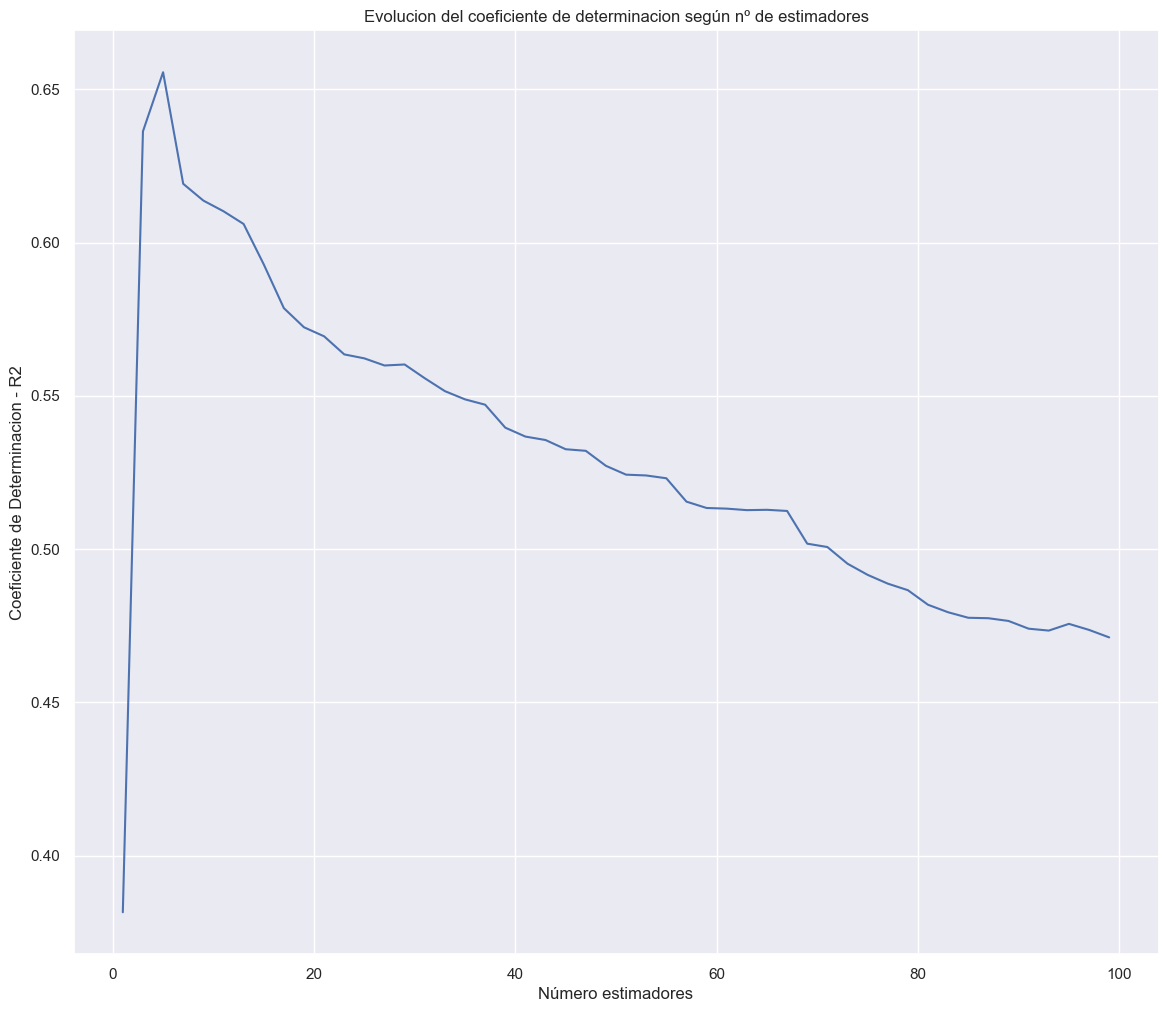

In [83]:
# Graficamos resultados
plt.figure()
plt.plot(rango_estimadores, r2_test_evol)
plt.xlabel('Número estimadores')
plt.ylabel('Coeficiente de Determinacion - R2')
plt.title('Evolucion del coeficiente de determinacion según nº de estimadores')
plt.show()

#### Redes Neuronales

Por último, vamos a intentar resolver el problema utilizando redes neuronales. Como estamos en un problema de regresión, haremos uso de MLP o Multilayer Perceptron.
Cada neurona de una capa está conectada con todas las neuronas de la capa siguiente, de ahí que se conozcan tambien como redes totalmente conectadas o feedforward. 

Utilizamos Keras, libreria dentro de tensor flow que facilita la construcción de las redes neuronales

In [68]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, metrics

Definimos manualmente la metrica r2, para ello utilizaremos el modulo Backend. Este es un módulo de Keras que proporciona una API de bajo nivel para operaciones matemáticas y funciones tensoriales. Actúa como una interfaz abstracta que permite que el código de Keras sea compatible con diferentes backends como TensorFlow.

In [70]:
import keras.backend as K

# Función personalizada para calcular R² Score
def r2_score(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))  # Suma de los cuadrados de los residuos
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))  # Suma total de los cuadrados
    return 1 - (ss_res / (ss_tot + K.epsilon()))  # Se añade K.epsilon() para evitar división por cero

##### Creación del modelo

El primer paso consiste en crear el modelo. Este será secuencial, es decir, cada capa tiene una entrada y una salida, siendo la salida de una capa la entrada de la siguiente. Además, serán capas tipo dense, es decir, capas de neuronas totalmente conectadas en las que todas las neuronas de una pasan su informacion a todas las neuronas de la capa siguiente.

Vamos a probar a utilizar distintas arquitecturas de red neuronal así como distintos optimizadores y funciones de pérdida.
Consideraremos lo siguiente:

**ARQUITECTURA RED NEURONAL**:

- Nº capas ocultas: en problemas simples entre 1-2 suficiente, en grandes de 3-10 podría bastar.
  
- Nº neuronas en capas ocultas: usaremos regla del embudo, de más a menos conforme pasamos de capa. Suelen usarse potencias de 2: 256, 128, 64, 32
  Por razones técnicas y prácticas: facilita reducccion progresiva de neuronas, eficientes al entrenamiento...

- Funciones de activacion: para capas ocultas probaremos con Relu y Tanh. En salida, como es problema de regresión no se aplicarán.

- Uso de capas dropout (desactivacion aleatoria neuronas) y capas batch normalization (normalizar salida capa anterior)

**OPTIMIZADOR Y FUNCION PERDIDA**:
- Loss: define como se calcula el error o la perdida durante el entreno, dicho de otra forma, que bien o mal el modelo ajusta sus predicciones a los datos reales. Probaremos con MSE y MAE.

- Optimizer: determina como se actualizan los pesos del modelo durante el entreno. Los más comunes son:

    -ADAM: Es el más común, se ajusta automáticamente a las tasas de aprendizaje y tiene buen rendimiento en muchos casos.
    
    -SGD: Es más lento que Adam y no ajusta automáticamente la tasa de aprendizaje. Se usa en casos donde se quiere más control sobre la optimización.


Hemos definido 4 modelos distintos, en cada uno de los cuales hemos duplicado el nº de capas ocultas: 1, 2, 4 y 8 capas ocultas respectivamente. Las características definidas en cada uno son aquellas que mejores métricas nos han proporcionado, tras haber tanteado en cada uno de ellos con todo lo optimizable comentado en lineas anteriores (nº neuronas, optmizador, función a optimizar, uso capas dropout y batch normalization). Los resultados obtenidos de todos ellos se encuentran recogidos en un archivo Excel adjunto en la entrega del proyecto.

**MODELO nº1**: 
1 Capa Oculta

In [136]:
model = keras.Sequential([
    layers.Dense(256, activation=tf.nn.tanh, input_shape=[X_train.shape[1]], name='h1'),    
    layers.Dense(1, name='o')
  ])

# Hay que compilar el modelo con la funcion de perdida, optimizador, metricas de evaluacion
model.compile(
    loss='mean_absolute_error', 
    optimizer=tf.keras.optimizers.Adam(), 
    metrics=['mean_absolute_error', r2_score])

# Mostramos un resumen de la estructura: con las capas del modelo, nº parametros y forma de las salidas 
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 h1 (Dense)                  (None, 256)               8192      
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 o (Dense)                   (None, 1)                 257       
                                                                 
Total params: 9,473
Trainable params: 8,961
Non-trainable params: 512
_________________________________________________________________


**MODELO nº2**: 2 capas ocultas

In [173]:
model = keras.Sequential([
    layers.Dense(256, activation=tf.nn.tanh, input_shape=[X_train.shape[1]], name='h1'),
    layers.Dense(128, activation=tf.nn.tanh, input_shape=[X_train.shape[1]], name='h2'), 
    layers.Dense(1, name='o')
  ])

# Hay que compilar el modelo con la funcion de perdida, optimizador, metricas de evaluacion
model.compile(
    loss='mean_absolute_error', 
    optimizer=tf.keras.optimizers.Adam(), 
    metrics=['mean_absolute_error', r2_score])

# Mostramos un resumen de la estructura: con las capas del modelo, nº parametros y forma de las salidas 
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 h1 (Dense)                  (None, 256)               8192      
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 batch_normalization_6 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 h2 (Dense)                  (None, 128)               32896     
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 batch_normalization_7 (Batc  (None, 128)              512       
 hNormalization)                                      

**MODELO nº3**: 4 capas ocultas

In [207]:
model = keras.Sequential([
    layers.Dense(256, use_bias=False, input_shape=[X_train.shape[1]], name='h1'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.1),

    layers.Dense(128, use_bias=False, name='h2'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.1),

    layers.Dense(64, use_bias=False, name='h3'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.1),

    layers.Dense(32, use_bias=False, name='h4'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.1),

    layers.Dense(1, name='o')
])

# Hay que compilar el modelo con la funcion de perdida, optimizador, metricas de evaluacion
model.compile(
    loss='mean_absolute_error', 
    optimizer=tf.keras.optimizers.Adam(), 
    metrics=['mean_absolute_error', r2_score])

# Mostramos un resumen de la estructura: con las capas del modelo, nº parametros y forma de las salidas 
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 h1 (Dense)                  (None, 256)               7936      
                                                                 
 batch_normalization_20 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 activation_6 (Activation)   (None, 256)               0         
                                                                 
 dropout_20 (Dropout)        (None, 256)               0         
                                                                 
 h2 (Dense)                  (None, 128)               32768     
                                                                 
 batch_normalization_21 (Bat  (None, 128)              512       
 chNormalization)                                    

**MODELO nº4**: 8 capas ocultas

In [232]:
model = keras.Sequential([
    layers.Dense(512, activation='relu', input_shape=[X_train.shape[1]], name='h1'),
    layers.Dense(256, activation='relu', name='h2'),
    layers.Dense(256, activation='relu', name='h3'),
    layers.Dense(128, activation='relu', name='h4'),
    layers.Dense(128, activation='relu', name='h5'),
    layers.Dense(64, activation='relu', name='h6'),
    layers.Dense(32, activation='relu', name='h7'),
    layers.Dense(16, activation='relu', name='h8'),
    layers.Dense(1, name='output')  # Output layer (sin activación si es regresión)
])


# Hay que compilar el modelo con la funcion de perdida, optimizador, metricas de evaluacion
model.compile(
    loss='mean_absolute_error', 
    optimizer=tf.keras.optimizers.Adam(), 
    metrics=['mean_absolute_error', r2_score])

# Mostramos un resumen de la estructura: con las capas del modelo, nº parametros y forma de las salidas 
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 h1 (Dense)                  (None, 512)               16384     
                                                                 
 batch_normalization_32 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 activation_18 (Activation)  (None, 512)               0         
                                                                 
 dropout_32 (Dropout)        (None, 512)               0         
                                                                 
 h2 (Dense)                  (None, 256)               131328    
                                                                 
 batch_normalization_33 (Bat  (None, 256)              1024      
 chNormalization)                                    

##### Entrenamiento del modelo y precisión 

El segundo paso es entrenar el modelo. Aquí también podemos considerar varios puntos para optimizar el resultado:

**ENTRENAMIENTO MODELO**:

- Nº de epochs

Si el modelo deja de mejorar después de cierto número de epochs, no necesitamos seguir entrenando. Para esto usamos el early stopping, que detiene el entrenamiento cuando no hay mejora en la métrica de validación durante un número determinado de epochs. Con ello, evitamos que el modelo siga entrenando y sobreajustando los datos, encontrando el punto óptimo del modelo

Además de evitarnos el sobreajuste el Early Stopping también reducira el tiemop de entreno, deteniendose el entrenamiento en el momento adecuado, lo que ahorra tiempo de computación sin sacrificar la calidad del modelo. Si el modelo ya no mejora en la métrica de validación, no tiene sentido seguir entrenando. 


- Conjunto de Validacion

¿Es validation_split obligatorio?
No, el parámetro validation_split no es obligatorio, pero es muy útil. El propósito de validation_split es reservar una parte de los datos de entrenamiento para la validación durante el mismo, lo cual ayuda a evaluar el rendimiento del modelo mientras está aprendiendo.

¿Por qué usar validation_split?
- Indicativo el sobreajuste (overfitting): Te permite monitorear el desempeño del modelo en datos no vistos durante el entrenamiento. Si la precisión en el conjunto de validación comienza a disminuir mientras que la de entrenamiento sigue mejorando, es una señal de sobreajuste.

- Monitoreo de la generalización: Ayuda a ver cómo el modelo generaliza a datos no vistos, lo cual es crucial para asegurar que el modelo no simplemente esté memorizando los datos de entrenamiento.

*Verbose: es un parámetro que me dice si quiero o no que me muestre un registro de como entrena el modelo

Por lo tanto, más que ir probando con distinta cantidad de epochs, lo que vamos a hacer usar el Early Stopping y consideraremos además un conjunto de validación de 0.2. 

Defino el Early Stopping:

In [117]:
from tensorflow.keras.callbacks import EarlyStopping

# Definir el callback EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',         # Métrica a monitorear. En este caso consideramos la perdida de los datos del conjunto de validación.
    patience=5,                # Número de epochs sin mejora antes de detener el entrenamiento
    restore_best_weights=True,  # Restaurar los pesos del modelo cuando se detenga el entrenamiento, con los mejores antes del stop (mejor metrica)
)

Ahora sí que sí, entrenamos el modelo:

In [234]:
#Se me devuelven todas las metricas que va generando el entreno, lo cual pinto en lineas posteriores
history = model.fit(X_train, y_train, epochs=500, validation_split=0.2, verbose=2, callbacks=[early_stopping])

Epoch 1/500
1142/1142 - 39s - loss: 93.3819 - mean_absolute_error: 93.3819 - r2_score: -2.6224e+00 - val_loss: 59.8831 - val_mean_absolute_error: 59.8831 - val_r2_score: -8.5625e-01 - 39s/epoch - 34ms/step
Epoch 2/500
1142/1142 - 24s - loss: 44.3541 - mean_absolute_error: 44.3541 - r2_score: -1.0693e-01 - val_loss: 35.0408 - val_mean_absolute_error: 35.0408 - val_r2_score: 0.3056 - 24s/epoch - 21ms/step
Epoch 3/500
1142/1142 - 27s - loss: 36.4692 - mean_absolute_error: 36.4692 - r2_score: 0.2933 - val_loss: 33.3063 - val_mean_absolute_error: 33.3063 - val_r2_score: 0.3765 - 27s/epoch - 23ms/step
Epoch 4/500
1142/1142 - 32s - loss: 35.8445 - mean_absolute_error: 35.8445 - r2_score: 0.2899 - val_loss: 32.9847 - val_mean_absolute_error: 32.9847 - val_r2_score: 0.3928 - 32s/epoch - 28ms/step
Epoch 5/500
1142/1142 - 32s - loss: 35.5578 - mean_absolute_error: 35.5578 - r2_score: 0.3222 - val_loss: 33.0380 - val_mean_absolute_error: 33.0380 - val_r2_score: 0.3960 - 32s/epoch - 28ms/step
Epoch

**PRECISIÓN DEL MODELO**

Tercero, obtenemos la precisión del modelo mediante el conjunto de testeo.
En Keras, la función model.evaluate() es utilizada para evaluar el rendimiento del modelo en un conjunto de datos (como los datos de test o entrenamiento). Esto es diferente al score en scikit-learn, ya que evaluate en Keras no solo devuelve la pérdida (loss) del modelo, sino también cualquier métrica que hayas definido (como precisión, MAE, etc.).

In [237]:
model.evaluate(X_test, y_test)

476/476 [==============================] - 4s 9ms/step - loss: 31.6946 - mean_absolute_error: 31.6946 - r2_score: 0.4467


[31.694637298583984, 31.694637298583984, 0.44669270515441895]

##### Gráfica de resultados de entreno

Procedemos a graficar la evolucion de los MAE y R2 durante el entrenamiento. 

Este código convierte el objeto history (que contiene las métricas de entrenamiento como la pérdida y precisión) en un DataFrame de pandas para facilitar su análisis y visualización. El atributo history.history contiene los valores de la pérdida y las métricas de cada época.

In [236]:
# history.history solo contiene información sobre el rendimiento durante el entrenamiento y la validación, no el test.
hist = pd.DataFrame(history.history)

# Incluye el epoch para cada error
hist['epoch'] = history.epoch

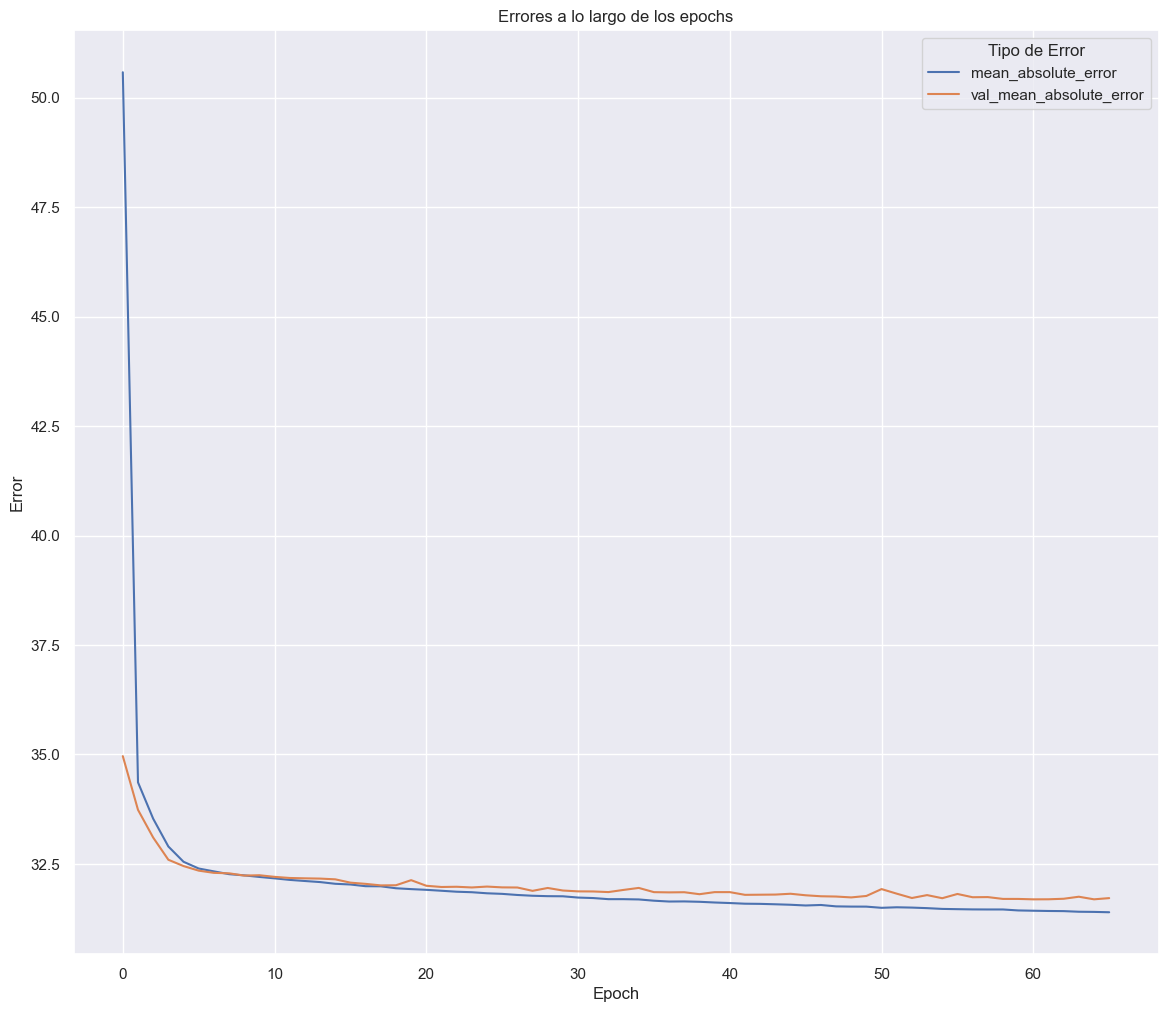

In [238]:
# Gráfico con Seaborn
# Colpasa los errores 'mean_absolute_error','val_mean_absolute_error' en una sola columna para sns
df = hist.melt(id_vars='epoch', var_name='Type', value_name='Error',
               value_vars=['mean_absolute_error','val_mean_absolute_error'])
sns.lineplot(x='epoch', y='Error', hue='Type', data=df)

# Mostrar los resultados
import matplotlib.pyplot as plt
plt.title("Errores a lo largo de los epochs")
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.legend(title="Tipo de Error")
plt.show()

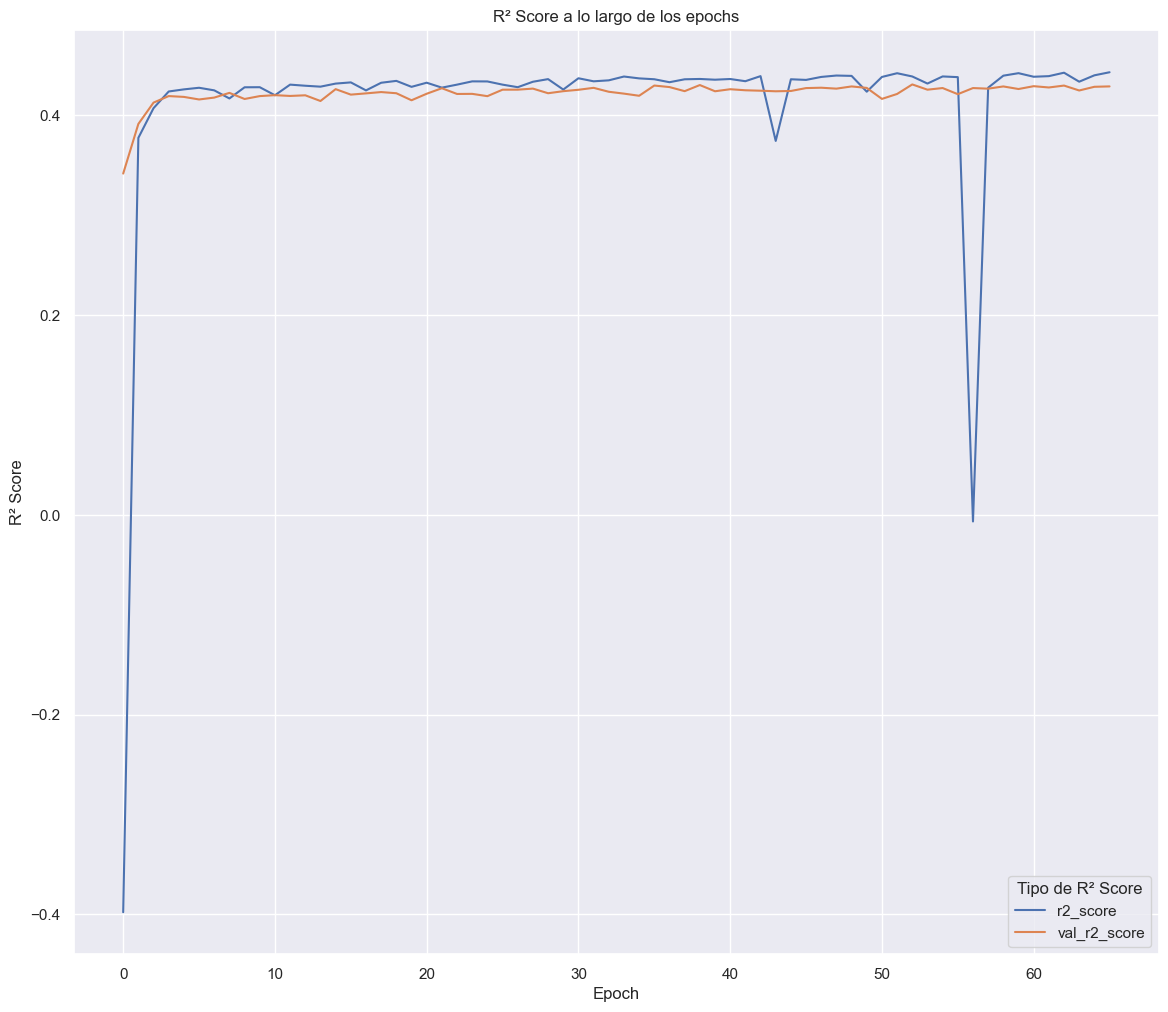

In [240]:
# Gráfico con Seaborn
# Colapsamos las métricas 'r2_score' y 'val_r2_score' en una sola columna para sns
df = hist.melt(id_vars='epoch', var_name='Type', value_name='R2_Score',
               value_vars=['r2_score', 'val_r2_score'])  # Aquí usamos 'r2_score' y 'val_r2_score'
sns.lineplot(x='epoch', y='R2_Score', hue='Type', data=df)

# Mostrar los resultados
plt.title("R² Score a lo largo de los epochs")
plt.xlabel("Epoch")
plt.ylabel("R² Score")
plt.legend(title="Tipo de R² Score")
plt.show()